In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pysam
from collections import Counter
from matplotlib import cm
from matplotlib.colors import ListedColormap

import warnings
warnings.filterwarnings("ignore")

import io
from pysam import VariantFile

from sklearn.metrics import precision_score, recall_score, average_precision_score, precision_recall_curve

In [2]:
def read_vcf(path):
    with open(path, 'r') as f:
        lines = [l for l in f if not l.startswith('##')]
    res = pd.read_csv(
        io.StringIO(''.join(lines)),
        dtype={'#CHROM': str, 'POS': int, 'ID': str, 'REF': str, 'ALT': str,
               'QUAL': str, 'FILTER': str, 'INFO': str},
        sep='\t'
    ).rename(columns={'#CHROM': 'CHROM'})
    return res

foo = lambda x: pd.Series(x.split('CALLERS=')[1].split(';')[0])

In [3]:
context = 'talk' # talk or paper

if context == 'talk':
    sns.set(style="darkgrid", context="talk", rc={"lines.linewidth": 2, "legend.fontsize":25})
    plt.style.use("dark_background")
    plt.rcParams.update({"grid.linewidth":0.5, "grid.alpha":0.5,'font.size': 30})
    sns.set_palette("deep")
else:
    sns.set(context="paper", font_scale=1.5, rc={"lines.linewidth": 1, "legend.fontsize":10})
    plt.rcParams.update({'font.size': 15})
    sns.set_palette("deep")

lc = 'w' if context == 'talk' else 'k'

In [4]:
methods = ['freebayes', 'mutect2', 'strelka2', 'vardict', 'varscan']
nmethods = len(methods)

In [5]:
tab20 = cm.get_cmap('tab10', 8)
newcmap_list = []
for i in range(4):
    newcmap_list.append(tab20.colors[i])
for i in range(4):
    newcmap_list.append(np.array(list(tab20.colors[i][:-1]) +[0.3]))

newcmap = ListedColormap(newcmap_list, name='newcmap')
color_list = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

In [6]:
dilutionseries = [(1,0), (1, 0.72), (0.75, 0.765), (0.5, 0.81), (0.25, 0.855), (0.125, 0.875)]
alpha_list = [1, 1, .8, .6, .4, .2, 0.1]

# Select plasma sample and reference

In [7]:
#sample = '809'
sample = '986'
#reference = 'pooledhealthy'
reference = 'lowtb'

In [8]:
if sample == '809':
    plasmasample1 = 'CRC-809_110914'
    plasmasample2 = 'CRC-809_030915'
    tumorsample1 = 'NCC_CRC-809_290714-T1W'
elif sample == '986':
    plasmasample1 = 'CRC-986_100215'
    plasmasample2 = 'CRC-986_261016'
    tumorsample1 = 'NCC_CRC-986_100215-T1W'

In [9]:
if reference == 'lowtb':
    if sample == '986':
        reference = 'CRC-986_300316'
    elif sample == '809':
        raise ValueError('no matched low tb sample')

print(reference) # pooledhealthy if not lowtb

CRC-986_300316


# Load SNV calls
## Calls of dilution series

In [46]:
vcf_pd_dict = {}
samples_dict = {}

for i, d in enumerate(dilutionseries):
    print('vcf_pd_'+str(i), d)
    d0 = str(d[0]).replace('.', '_')
    d1 = str(d[1]).replace('.', '_')
    vcf_paths = [os.path.join("..","data","bcbio_output", "dilution_chr22_"+plasmasample1+"_"+str(d[0])+"_"+reference+"_"+str(d[1]),
                                                        "dilution_chr22_"+plasmasample1+"_"+d0+"_"+reference+"_"+d1+"-"+method+"-annotated.vcf")
                 for method in methods]
    if os.path.exists(vcf_paths[0]):
        vcf_pd_dict['vcf_pd_'+str(i)] = pd.concat([read_vcf(vcf_path) for vcf_path in vcf_paths], keys=methods)
        vcf_pd_dict['vcf_pd_'+str(i)].reset_index(inplace=True, col_level=0) 
        vcf_pd_dict['vcf_pd_'+str(i)].rename(columns={'level_0': 'callers'}, inplace=True)
        vcf_pd_dict['vcf_pd_'+str(i)] = vcf_pd_dict['vcf_pd_'+str(i)][vcf_pd_dict['vcf_pd_'+str(i)]['CHROM'] == '22']
        
        vcf_pd_dict['vcf_pd_'+str(i)]['type'] = np.nan
        vcf_pd_dict['vcf_pd_'+str(i)]['type'][vcf_pd_dict['vcf_pd_'+str(i)]['ALT'].str.len() - vcf_pd_dict['vcf_pd_'+str(i)]['REF'].str.len() == 0] = 'SNV'
        vcf_pd_dict['vcf_pd_'+str(i)]['type'][vcf_pd_dict['vcf_pd_'+str(i)]['ALT'].str.len() - vcf_pd_dict['vcf_pd_'+str(i)]['REF'].str.len() > 0] = 'INS'
        vcf_pd_dict['vcf_pd_'+str(i)]['type'][vcf_pd_dict['vcf_pd_'+str(i)]['ALT'].str.len() - vcf_pd_dict['vcf_pd_'+str(i)]['REF'].str.len() < 0] = 'DEL'
        vcf_pd_dict['vcf_pd_'+str(i)]['type'][vcf_pd_dict['vcf_pd_'+str(i)]['ID'].str.contains('rs')] = 'SNP'
        for m in methods:
            vcf_pd_dict['vcf_pd_'+str(i)][m] = vcf_pd_dict['vcf_pd_'+str(i)]['callers'].str.contains(m)
            # vcf_pd_dict['vcf_pd_'+str(i)][m][vcf_pd_dict['vcf_pd_'+str(i)][m] == True] = vcf_pd_dict['vcf_pd_'+str(i)]['FILTER']

        sample = vcf_pd_dict['vcf_pd_'+str(i)][['CHROM', 'POS', 'REF', 'ALT', 'type', *methods]] # QUAL
        #sample['CHROM_POS'] = sample['CHROM'].astype('str').str.cat(sample['POS'].astype('str'),sep="_")
        sample['CHROM_POS_REF_ALT_TYPE'] = sample['CHROM'].astype('str').str.cat(sample['POS'].astype('str'),sep="_") + '_' + sample['REF'].astype('str').str.cat(sample['ALT'].astype('str'),sep="_") + "_" + sample['type'].astype('str') 
        #sample.set_index('CHROM_POS', inplace = True)
        sample.set_index('CHROM_POS_REF_ALT_TYPE', inplace = True)
        #sample.drop(['CHROM', 'POS'], axis=1, inplace=True)
        sample.drop(['CHROM', 'POS', 'REF', 'ALT', 'type'], axis=1, inplace=True)
        sample = sample.groupby(level=0).sum()
        sample[sample != 0] = True
        sample[sample == 0] = False
        samples_dict['sample_'+str(i)] = sample

nsamples = len(vcf_pd_dict.keys())
vcf_pd_dict['vcf_pd_'+str(nsamples-1)].head()

vcf_pd_0 (1, 0)
vcf_pd_1 (1, 0.72)
vcf_pd_2 (0.75, 0.765)
vcf_pd_3 (0.5, 0.81)
vcf_pd_4 (0.25, 0.855)
vcf_pd_5 (0.125, 0.875)


callers  level_1 CHROM       POS           ID REF ALT    QUAL  FILTER  \
490  freebayes      490    22  16050933  rs200028125   G   A  9419.9  REJECT   
491  freebayes      491    22  16051075  rs587625303   G   A  2835.1  REJECT   
492  freebayes      492    22  16051165  rs587731798   C   T  2779.8  REJECT   
493  freebayes      493    22  16051968    rs2096600   C   A  4300.2  REJECT   
494  freebayes      494    22  16052080    rs4965031   G   A  9356.4  REJECT   

                                                  INFO  \
490  AB=0.560501;ABP=25.8697;AC=2;AF=0.5;AN=4;AO=40...   
491  AB=0.238231;ABP=420.233;AC=2;AF=0.5;AN=4;AO=16...   
492  AB=0.249581;ABP=328.189;AC=2;AF=0.5;AN=4;AO=14...   
493  AB=0.451902;ABP=11.9925;AC=2;AF=0.5;AN=4;AO=20...   
494  AB=0.555053;ABP=20.464;AC=2;AF=0.5;AN=4;AO=368...   

                         FORMAT  \
490  GT:GQ:DP:AD:RO:QR:AO:QA:GL   
491  GT:GQ:DP:AD:RO:QR:AO:QA:GL   
492  GT:GQ:DP:AD:RO:QR:AO:QA:GL   
493  GT:GQ:DP:AD:RO:QR:AO:QA:GL   
494  GT:GQ:DP:AD:RO:QR:AO:QA:GL   

    dilution_chr22_CRC-986_100215_0_125_CRC-986_300316_0_875-T  \
490  0/1:160:655:292,363:292:10712:363:13059:-854.3...           
491  0/1:160:652:496,156:496:17850:156:5638:-266.87...           
492  0/1:139:557:416,139:416:15090:139:5040:-263.56...           
493  0/1:142:401:215,186:215:7853:186:6694:-399.737...           
494  0/1:144:614:271,341:271:9627:341:12202:-865.58...           

    dilution_chr22_CRC-986_100215_0_125_CRC-986_300316_0_875-N type  \
490  0/1:160:64:24,40:24:976:40:1458:-95.6807,0,-54...          SNP   
491  0/1:160:49:36,11:36:1350:11:451:-25.9936,0,-10...          SNP   
492  0/1:139:40:30,10:30:1217:10:392:-23.4879,0,-96...          SNP   
493  0/1:142:46:30,16:30:1174:16:635:-42.434,0,-72....          SNP   
494  0/1:144:49:22,27:22:862:27:1067:-78.7958,0,-63...          SNP   

     freebayes  mutect2  strelka2  vardict  varscan  
490       True    False     False    False    False  
491       True    False     False    False    False  
492       True    False     False    False    False  
493       True    False     False    False    False  
494       True    False     False    False    False

In [47]:
samples_dict['sample_0']

freebayes mutect2 strelka2 vardict varscan
CHROM_POS_REF_ALT_TYPE                                           
22_16050252_A_T_SNP        False   False     True   False   False
22_16050612_C_G_SNP        False   False     True    True   False
22_16050933_G_A_SNP         True   False    False    True    True
22_16051075_G_A_SNP         True   False    False    True    True
22_16051165_C_T_SNP         True   False     True    True    True
...                          ...     ...      ...     ...     ...
22_51243069_A_AT_INS        True   False     True    True    True
22_51243081_C_T_SNV        False   False     True   False   False
22_51243170_G_A_SNV        False   False     True   False   False
22_51244056_G_A_SNV        False   False    False   False    True
22_51244267_T_C_SNV        False   False    False   False    True

[158959 rows x 5 columns]

## Calls of second plasma sample

In [100]:
vcf_path = os.path.join("..","data","bcbio_output", 'chr22_'+plasmasample2,
                                                    'chr22_'+plasmasample2+"-ensemble-annotated.vcf")
if os.path.exists(vcf_path):
    vcf_pd_dict['vcf_pd_0_bis'] = read_vcf(vcf_path)
    
    vcf_pd_dict['vcf_pd_0_bis']['callers'] = vcf_pd_dict['vcf_pd_0_bis']['INFO'].apply(foo)
    vcf_pd_dict['vcf_pd_0_bis']['type'] = np.nan
    vcf_pd_dict['vcf_pd_0_bis']['type'][vcf_pd_dict['vcf_pd_0_bis']['ALT'].str.len() - vcf_pd_dict['vcf_pd_0_bis']['REF'].str.len() == 0] = 'SNV'
    vcf_pd_dict['vcf_pd_0_bis']['type'][vcf_pd_dict['vcf_pd_0_bis']['ALT'].str.len() - vcf_pd_dict['vcf_pd_0_bis']['REF'].str.len() > 0] = 'INS'
    vcf_pd_dict['vcf_pd_0_bis']['type'][vcf_pd_dict['vcf_pd_0_bis']['ALT'].str.len() - vcf_pd_dict['vcf_pd_0_bis']['REF'].str.len() < 0] = 'DEL'
    vcf_pd_dict['vcf_pd_0_bis']['type'][vcf_pd_dict['vcf_pd_0_bis']['ID'].str.contains('rs')] = 'SNP'
    for m in methods:
        vcf_pd_dict['vcf_pd_0_bis'][m] = vcf_pd_dict['vcf_pd_0_bis']['INFO'].str.contains(m)
        
    sample = vcf_pd_dict['vcf_pd_0_bis'][['CHROM', 'POS', 'REF', 'ALT', 'QUAL', 'FILTER', 'type', *methods]]
    sample['CHROM_POS'] = sample['CHROM'].astype('str').str.cat(sample['POS'].astype('str'),sep="_")
    sample.set_index('CHROM_POS', inplace = True)
    sample = sample[sample['CHROM'] == '22']
    samples_dict['sample_0_bis'] = sample

    l1 = list(samples_dict['sample_0'].index)
    l2 = list(samples_dict['sample_0_bis'].index)
    print(len(l1), len(l2))
    print(len(list(set(set(l1) & set(l2)))))

8066 18011
2431


## Calls of matched tumor

In [97]:
vcf_path = os.path.join("..","data","bcbio_output", tumorsample1, tumorsample1+"-ensemble-annotated.vcf")
if os.path.exists(vcf_path):
    vcf_pd_dict['vcf_pd_t'] = read_vcf(vcf_path)
    
    vcf_pd_dict['vcf_pd_t']['callers'] = vcf_pd_dict['vcf_pd_t']['INFO'].apply(foo)
    vcf_pd_dict['vcf_pd_t']['type'] = np.nan
    vcf_pd_dict['vcf_pd_t']['type'][vcf_pd_dict['vcf_pd_t']['ALT'].str.len() - vcf_pd_dict['vcf_pd_t']['REF'].str.len() == 0] = 'SNV'
    vcf_pd_dict['vcf_pd_t']['type'][vcf_pd_dict['vcf_pd_t']['ALT'].str.len() - vcf_pd_dict['vcf_pd_t']['REF'].str.len() > 0] = 'INS'
    vcf_pd_dict['vcf_pd_t']['type'][vcf_pd_dict['vcf_pd_t']['ALT'].str.len() - vcf_pd_dict['vcf_pd_t']['REF'].str.len() < 0] = 'DEL'
    vcf_pd_dict['vcf_pd_t']['type'][vcf_pd_dict['vcf_pd_t']['ID'].str.contains('rs')] = 'SNP'
    for m in methods:
        vcf_pd_dict['vcf_pd_t'][m] = vcf_pd_dict['vcf_pd_t']['INFO'].str.contains(m)
        
    sample = vcf_pd_dict['vcf_pd_t'][['CHROM', 'POS', 'REF', 'ALT', 'QUAL', 'FILTER', 'type', *methods]]
    sample['CHROM_POS'] = sample['CHROM'].astype('str').str.cat(sample['POS'].astype('str'),sep="_")
    sample.set_index('CHROM_POS', inplace = True)
    sample = sample[sample['CHROM'] == '22']
    samples_dict['sample_t'] = sample
    
l1 = list(samples_dict['sample_t'].index)
l2 = list(samples_dict['sample_0'].index)
print(len(l1), len(l2))
print(len(list(set(set(l1) & set(l2)))))

703 8066
206


# Estimated tumor burden of mixed samples

In [48]:
samples_tf = {}
for i in range(nsamples):
    samples_tf['sample_'+str(i)] = float(list(pd.read_csv(os.path.join(
        "..","data", "dilutions_chr22",
        "estimated_tf_chr22_"+plasmasample1+"_"+str(dilutionseries[i][0])+"_"+reference+"_"+str(dilutionseries[i][1])+".txt")).columns)[0])
print(samples_tf)

{'sample_0': 0.41899930338493496, 'sample_1': 0.14519445902440323, 'sample_2': 0.1141212376235114, 'sample_3': 0.07991588194289494, 'sample_4': 0.042078687380936224, 'sample_5': 0.021671520813139816}


# Depth of coverage of mixed samples

{'sample_0': [50.2097, 0.41899930338493496], 'sample_1': [217.874, 0.14519445902440323], 'sample_2': [215.812, 0.1141212376235114], 'sample_3': [213.758, 0.07991588194289494], 'sample_4': [211.705, 0.042078687380936224], 'sample_5': [210.105, 0.021671520813139816]}


coverage  tumor burden
sample_0   50.2097          0.42
sample_1  217.8740          0.15
sample_2  215.8120          0.11
sample_3  213.7580          0.08
sample_4  211.7050          0.04
sample_5  210.1050          0.02

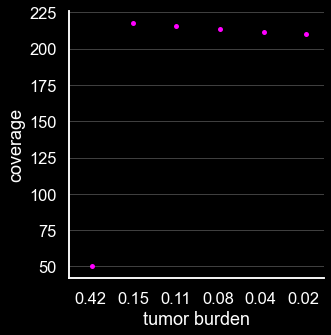

In [49]:
samples_cov = {}
for i in range(nsamples):
    ## OLD TO UPDATE
    samples_cov['sample_'+str(i)] = [float(list(pd.read_csv(os.path.join(
        "..","data", "dilutions_chr22",
        "coverage_chr22_"+plasmasample1+"_"+str(dilutionseries[i][0])+"_"+reference+"_"+str(dilutionseries[i][1])+".txt")).columns)[0]),
                                     float(list(pd.read_csv(os.path.join(
        "..","data", "dilutions_chr22",
        "estimated_tf_chr22_"+plasmasample1+"_"+str(dilutionseries[i][0])+"_"+reference+"_"+str(dilutionseries[i][1])+".txt")).columns)[0])]
print(samples_cov)


coverage_pd = pd.DataFrame.from_dict(samples_cov).T
coverage_pd.columns = ['coverage', 'tumor burden']
coverage_pd = coverage_pd.round({'tumor burden': 2}) 
sns.catplot(x='tumor burden', y='coverage', data=coverage_pd,
            order=sorted(coverage_pd['tumor burden'].unique(), reverse=True), color='magenta')
        
coverage_pd

# Number of detections detected

In [50]:
samples = list(samples_dict.values())[:nsamples]
len(samples)

6

          freebayes  mutect2  strelka2  vardict  varscan
0.418999      76251     2984     75639    73304    67594
0.145194      79111     7847     46057    73787    73409
0.114121      78898     7629     45250    72175    72878
0.079916      78923     7680     44632    72207    72976
0.042079      78335     7849     44912    72347    73457
0.021672      79212     7623     44368    73517    72795
          freebayes  mutect2  strelka2  vardict  varscan
0.418999       2581      319      1555     3026     2022
0.145194       3345     1660      4620     2839     2538
0.114121       3423     1731      4557     2713     2562
0.079916       3421     1814      4496     2752     2639
0.042079       3392     1860      4453     2781     2670
0.021672       3523     1877      4427     2929     2682
          freebayes  mutect2  strelka2  vardict  varscan
0.418999       4948     1494     56313     4709     4192
0.145194       5030     3216     23120     4316     4652
0.114121       4993     3099   

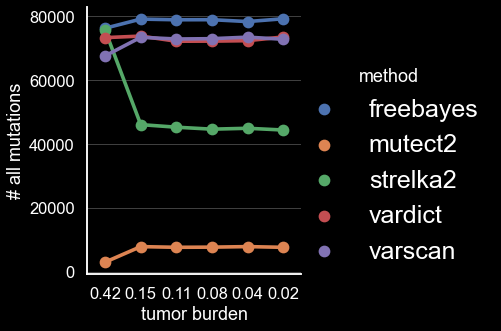

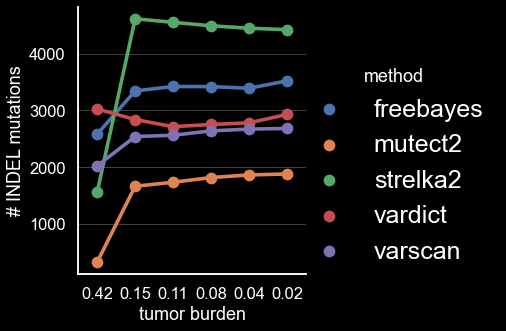

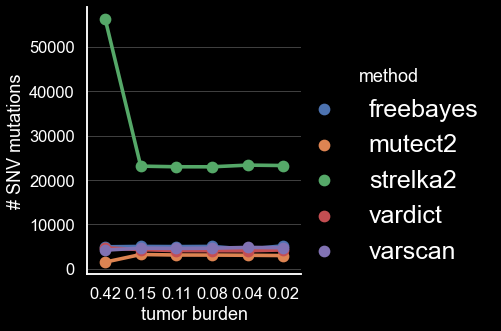

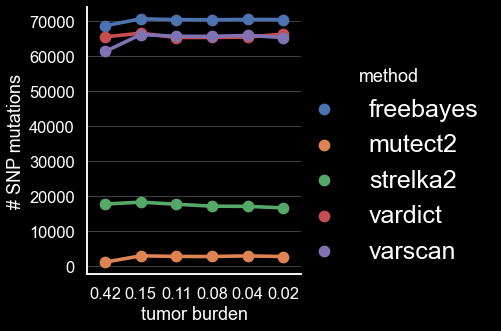

In [53]:
for mutationtype in ['all', 'INDEL', 'SNV', 'SNP']:
    numbersnvs_pd = pd.DataFrame()

    for si, s in enumerate(samples):
        nb_snv = []
        for method in methods:
            if mutationtype == 'all':
                nb_snv.append(s[s[method] == True].shape[0])
            elif mutationtype == 'INDEL':
                nb_snv.append(s[(s[method] == True) & (s.index.str.contains('INS') | s.index.str.contains('DEL'))].shape[0])
            elif mutationtype == 'SNV':
                nb_snv.append(s[(s[method] == True) & (s.index.str.contains('SNV'))].shape[0])
            elif mutationtype == 'SNP':
                nb_snv.append(s[(s[method] == True) & (s.index.str.contains('SNP'))].shape[0])
            else:
                raise ValueError('mutation type {} unknown'.format(mutationtype))
        if si == 0:
            numbersnvs_pd = pd.DataFrame.from_dict({'sample_'+ str(si): nb_snv}).T
            numbersnvs_pd.columns = methods
        else:
            numbersnvs_pd.loc['sample_'+ str(si)] = nb_snv
        numbersnvs_pd = numbersnvs_pd.rename(index=samples_tf)

    numbersnvs_pd_aux = numbersnvs_pd.reset_index()
    numbersnvs_pd_aux = numbersnvs_pd_aux.rename(columns = {'index':'tumor burden'})
    numbersnvs_pd_aux = pd.melt(numbersnvs_pd_aux, id_vars=['tumor burden'], value_vars=methods, var_name='method', value_name='# '+ mutationtype +' mutations')
    numbersnvs_pd_aux = numbersnvs_pd_aux.rename(columns = {'index':'tumor burden'})
    numbersnvs_pd_aux = numbersnvs_pd_aux.round({'tumor burden': 2}) 
    sns.catplot(x='tumor burden', y='# '+ mutationtype +' mutations', kind='point', data=numbersnvs_pd_aux, hue='method',
               order=sorted(numbersnvs_pd_aux['tumor burden'].unique(), reverse=True), title=mutationtype)

    print(numbersnvs_pd)

In [72]:
sample_all = pd.concat(samples, axis=1)
sample_all.fillna(False, inplace=True)

In [92]:
#plt.figure(figsize=(15,15))
#sns.heatmap(sample_all, cmap=cmap_list[si])

f, axs = plt.subplots(1, sample_all.columns.size, gridspec_kw={'wspace': 0})
for i, (s, a, c) in enumerate(zip(sample_all.columns, axs, cmap_list*6)):
    sns.heatmap(np.squeeze(np.array([sample_all[s].values]).T), yticklabels=sample_all.index, xticklabels=[s], ax=a, cmap=c, cbar=False)
    if i>0:
        a.yaxis.set_ticks([])
plt.show()

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7ff7b1686b90> (for post_execute):


KeyboardInterrupt: 

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

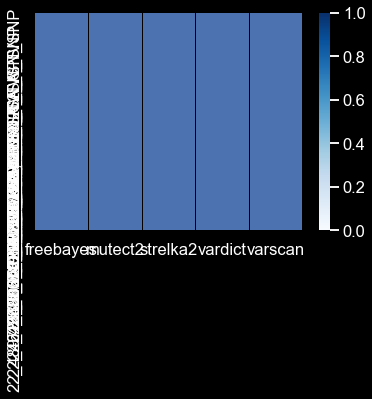

In [66]:
cmap_list=['Blues', 'Oranges', 'Greens', 'Reds', 'Purples']

for mutation in ['snv', 'indels']:
    for si, sample in enumerate(samples.copy()):
        sample['type'] = sample.index.str.split('_').str[-1]
        if mutation == 'snv':
            pd_method = sample[sample['type'] == 'SNV']
        elif mutation == 'indel':
            pd_method = sample[(sample['type'] == 'INS') | (sample['type'] == 'DEL')]
        sample.drop('type', axis=1, inplace=True)
        
        plt.figure()
        sns.heatmap(sample, cmap=cmap_list[si])
        #plt.title('snv' + ' ' + methods[i])
        plt.show()

# Reference = SNV found in undiluted plasma sample by the same method

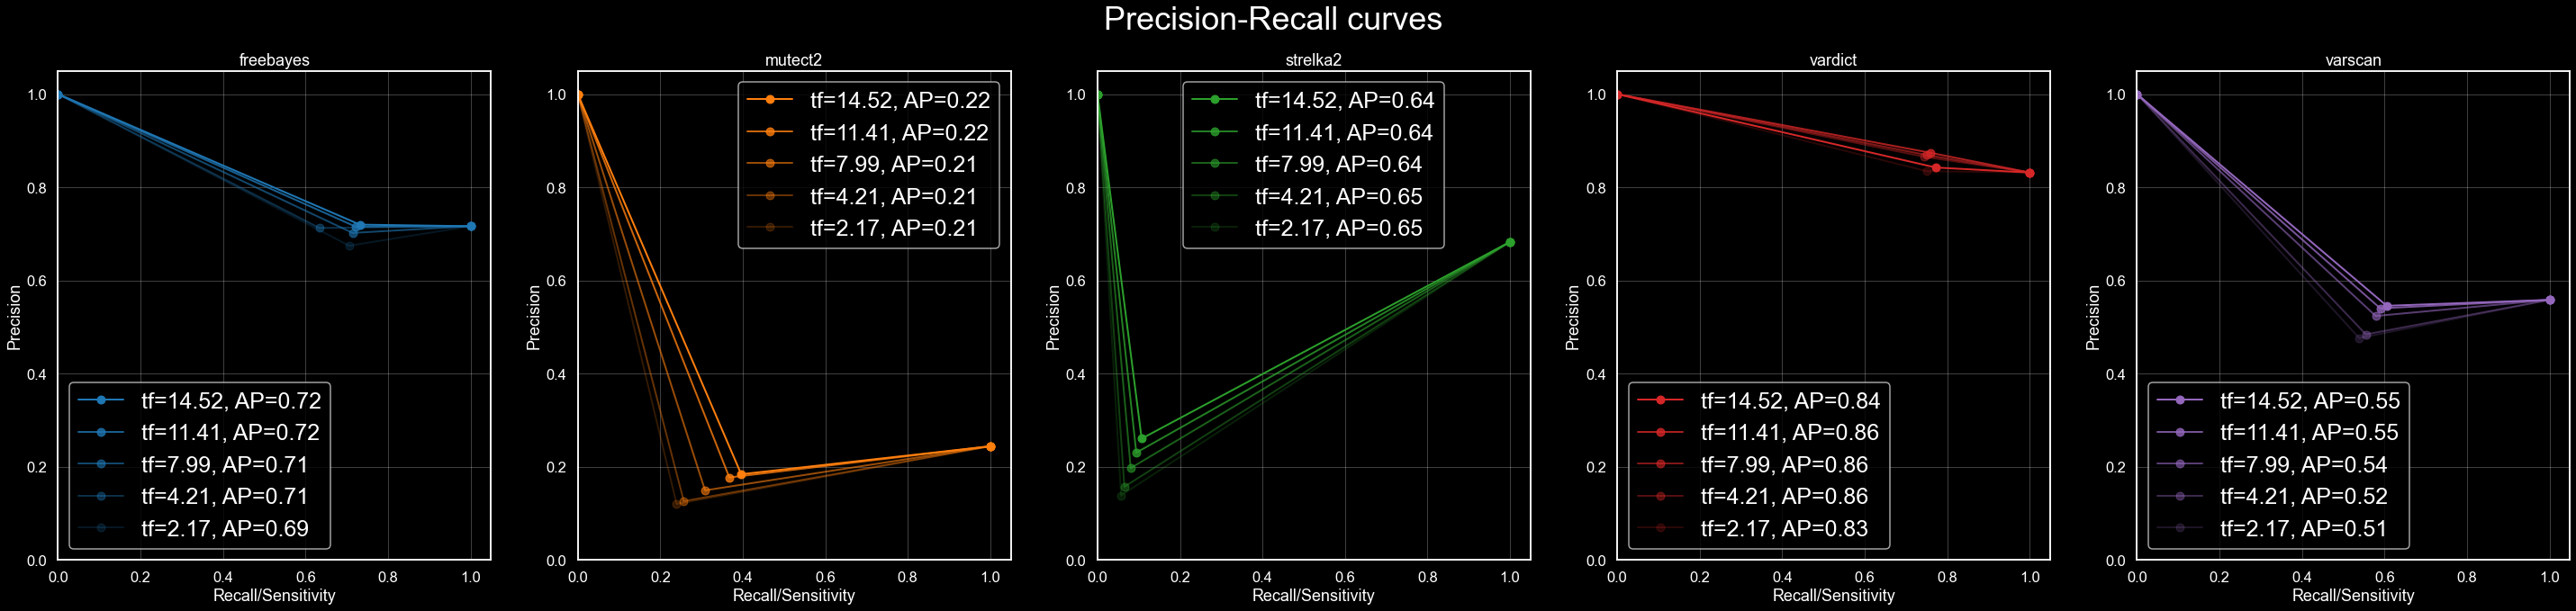

<Figure size 432x288 with 0 Axes>

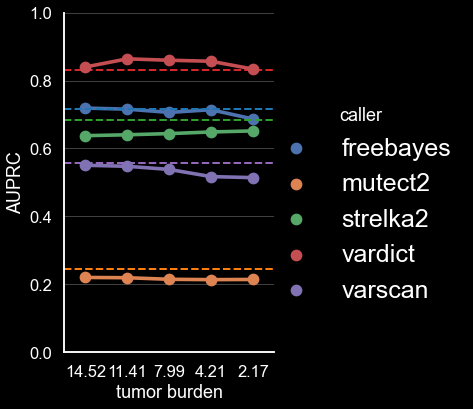

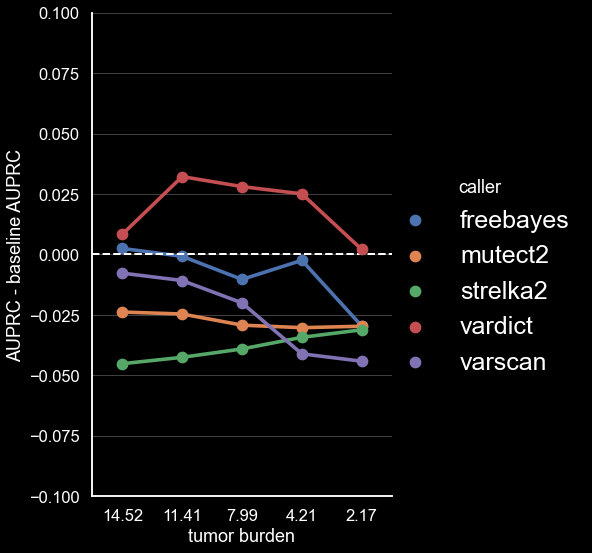

<Figure size 432x288 with 0 Axes>

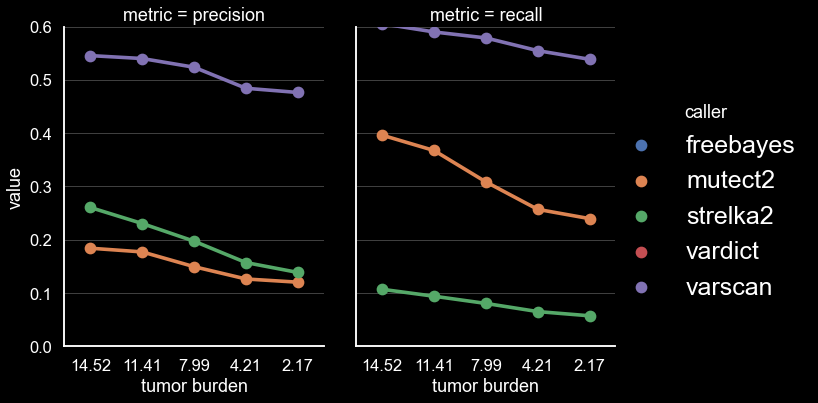

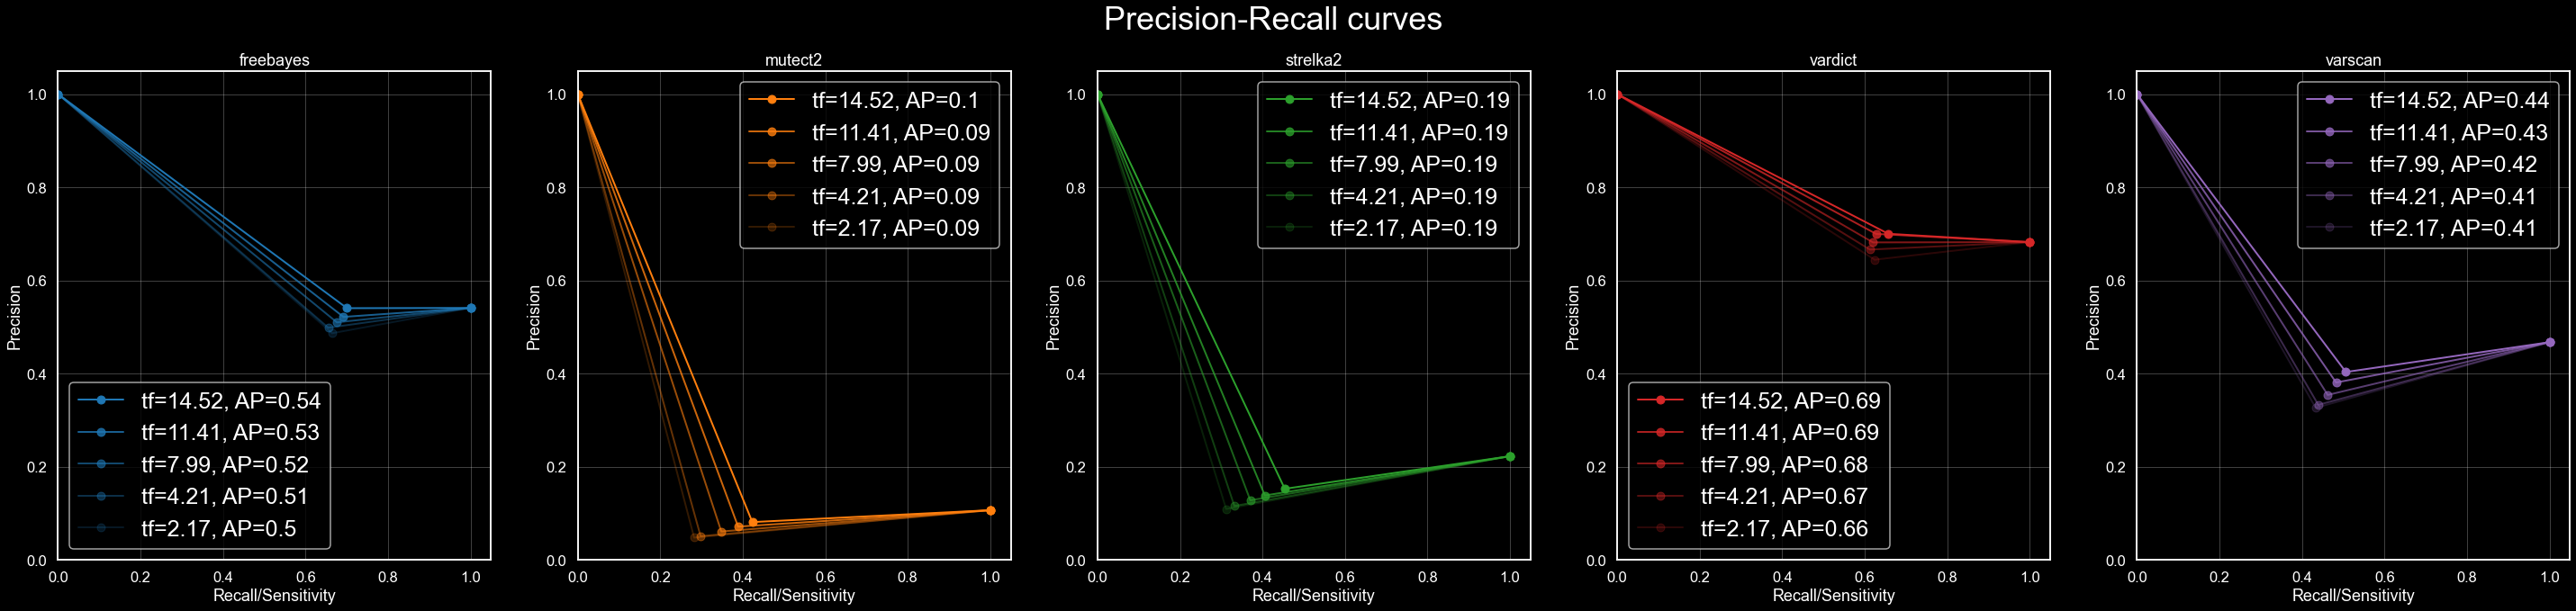

<Figure size 432x288 with 0 Axes>

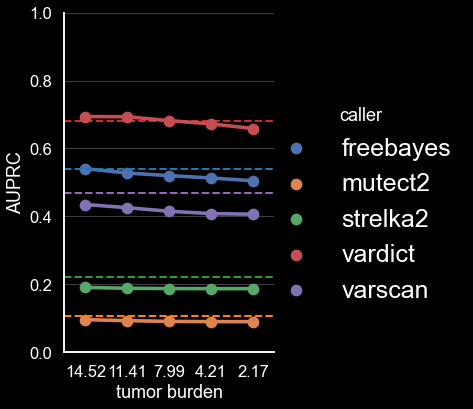

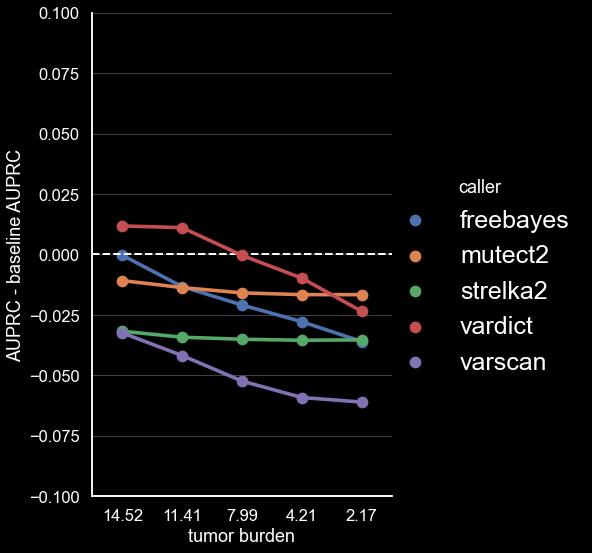

<Figure size 432x288 with 0 Axes>

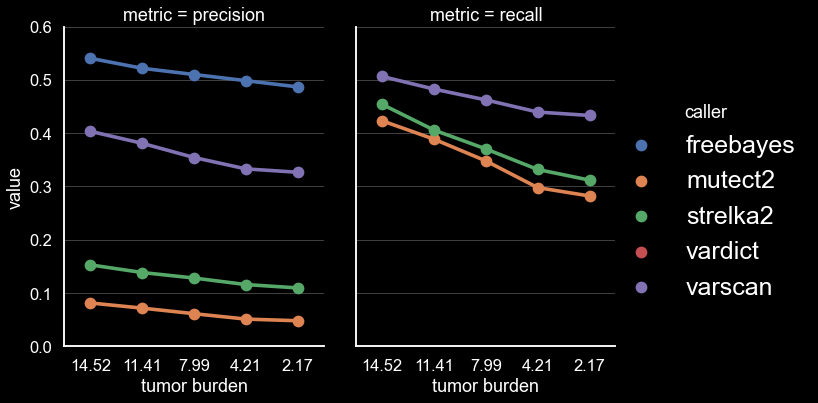

In [62]:
for mutation in ['snv', 'indel']:
    pd_methods = pd.DataFrame
    count = 0

    for mi, method in enumerate(methods):
        
        slist = []

        for i, sample in enumerate(samples):
            if i == 0:
                si = sample[[method]]
            else:
                si = sample[[method]]
            si.rename(columns = {method:'sample_'+str(i)},  inplace = True)
            slist.append(si)
        pd_method = pd.concat(slist, axis=1)

        pd_method.columns = ['sample_'+str(i) for i in range(nsamples)]
        pd_method[list(samples_dict.keys())[:nsamples]] = pd_method[list(samples_dict.keys())[:nsamples]].fillna(value=False)
        pd_method.drop(pd_method[sum(pd_method['sample_'+str(i)] for i in range(nsamples)) == False].index, axis=0, inplace=True)
        pd_method['caller'] = method
        pd_method['type'] = pd_method.index.str.split('_').str[-1]

        if mutation == 'snv':
            pd_method = pd_method[pd_method['type'] == 'SNV']
        elif mutation == 'indel':
            pd_method = pd_method[(pd_method['type'] == 'INS') | (pd_method['type'] == 'DEL')]
                                
        if count == 0:
            pd_methods = pd_method
            count = 1
        else:
            pd_methods = pd.concat([pd_methods, pd_method], join='inner')

    pd_results = pd.DataFrame
    pd_results_PR = pd.DataFrame
    count = 0

    fig, axs = plt.subplots(1,nmethods,figsize=(50, 10))
    fig.suptitle('Precision-Recall curves')

    baselineAUPRC = {}

    for mi, method in enumerate(methods):

        res_df = (100*pd.Series(samples_tf)).round(decimals=2).to_frame(name='tumor burden')
        res_PR_df = (100*pd.Series(samples_tf)).round(decimals=2).to_frame(name='tumor burden')

        y_list = []
        y_true = pd_methods[pd_methods['caller'] == method]['sample_0'].astype(bool)
        baselineAUPRC[method] = len(y_true[y_true == True])/len(y_true)
        for i in range(nsamples):
            y_i = pd_methods[pd_methods['caller'] == method]['sample_'+str(i)].astype(bool).reindex(y_true.index).squeeze()
            y_i = y_i.fillna(False)
            y_list.append(y_i)

        res_df['AUPRC'] = [average_precision_score(y_true, y_i) for y_i in y_list]  
        res_df['AUPRC - baseline AUPRC'] = [average_precision_score(y_true, y_i) - baselineAUPRC[method] for y_i in y_list]
        res_PR_df['precision'] = [precision_score(y_true, y_i) for y_i in y_list]
        res_PR_df['recall'] = [recall_score(y_true, y_i) for y_i in y_list]

        res_PR_df = pd.melt(res_PR_df, id_vars =['tumor burden'], value_vars =['precision', 'recall'],
                        var_name='metric', value_name='value')
        res_df['caller'] = method
        res_PR_df['caller'] = method

        res_df.drop(['sample_0'], inplace=True)
        res_PR_df.drop([0, nsamples], inplace=True)

        
        # Plot Precision-Recall curve
        for i in range(1,nsamples):
            y_i = pd_methods[pd_methods['caller'] == method]['sample_'+str(i)].astype(bool).reindex(y_true.index).squeeze()
            y_i = y_i.fillna(False)
            precision, recall, _ = precision_recall_curve(y_true, y_i)
            axs[mi].plot(recall, precision, 'o-',
                                  label='tf='+str(res_df['tumor burden'].loc['sample_'+str(i)])+ ', AP='+str(round(average_precision_score(y_true, y_i), 2)),
                                  c=color_list[mi], alpha=alpha_list[i])
        axs[mi].set_xlabel('Recall/Sensitivity')
        axs[mi].set_ylabel('Precision')
        axs[mi].set_ylim([0.0, 1.05])
        axs[mi].set_xlim([0.0, 1.05])
        axs[mi].set_title(method)
        axs[mi].legend()

        if count == 0:
            pd_results = res_df
            pd_results_PR = res_PR_df
            count = 1
        else:
            pd_results = pd.concat([pd_results, res_df], join='inner')
            pd_results_PR = pd.concat([pd_results_PR, res_PR_df], join='inner')
    plt.show()

    plt.figure()
    sns.catplot(x="tumor burden", y="AUPRC", hue="caller",  
                    capsize=.2, height=6, aspect=.75,
                    kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results)
    for mi, method in enumerate(methods):
        plt.axhline(y = baselineAUPRC[method], color = color_list[mi], linestyle = '--') 
    plt.ylim([0, 1])
    
    sns.catplot(x="tumor burden", y="AUPRC - baseline AUPRC", hue="caller",  
                capsize=.2, height=8, aspect=.75,
                kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results)
    plt.axhline(y = 0, color = lc, linestyle = '--', label='baseline AUPRC') 
    plt.ylim([-0.1, 0.1])

    plt.figure()
    sns.catplot(x="tumor burden", y="value", col="metric", hue="caller",  
                    capsize=.2, height=6, aspect=.75,
                    kind="point", order=sorted(pd_results_PR['tumor burden'].unique(), reverse=True), data=pd_results_PR)
    plt.ylim([0, 0.6])

# Reference = SNV found in undiluted plasma sample by at least 3 methods

4657
(5242, 22)


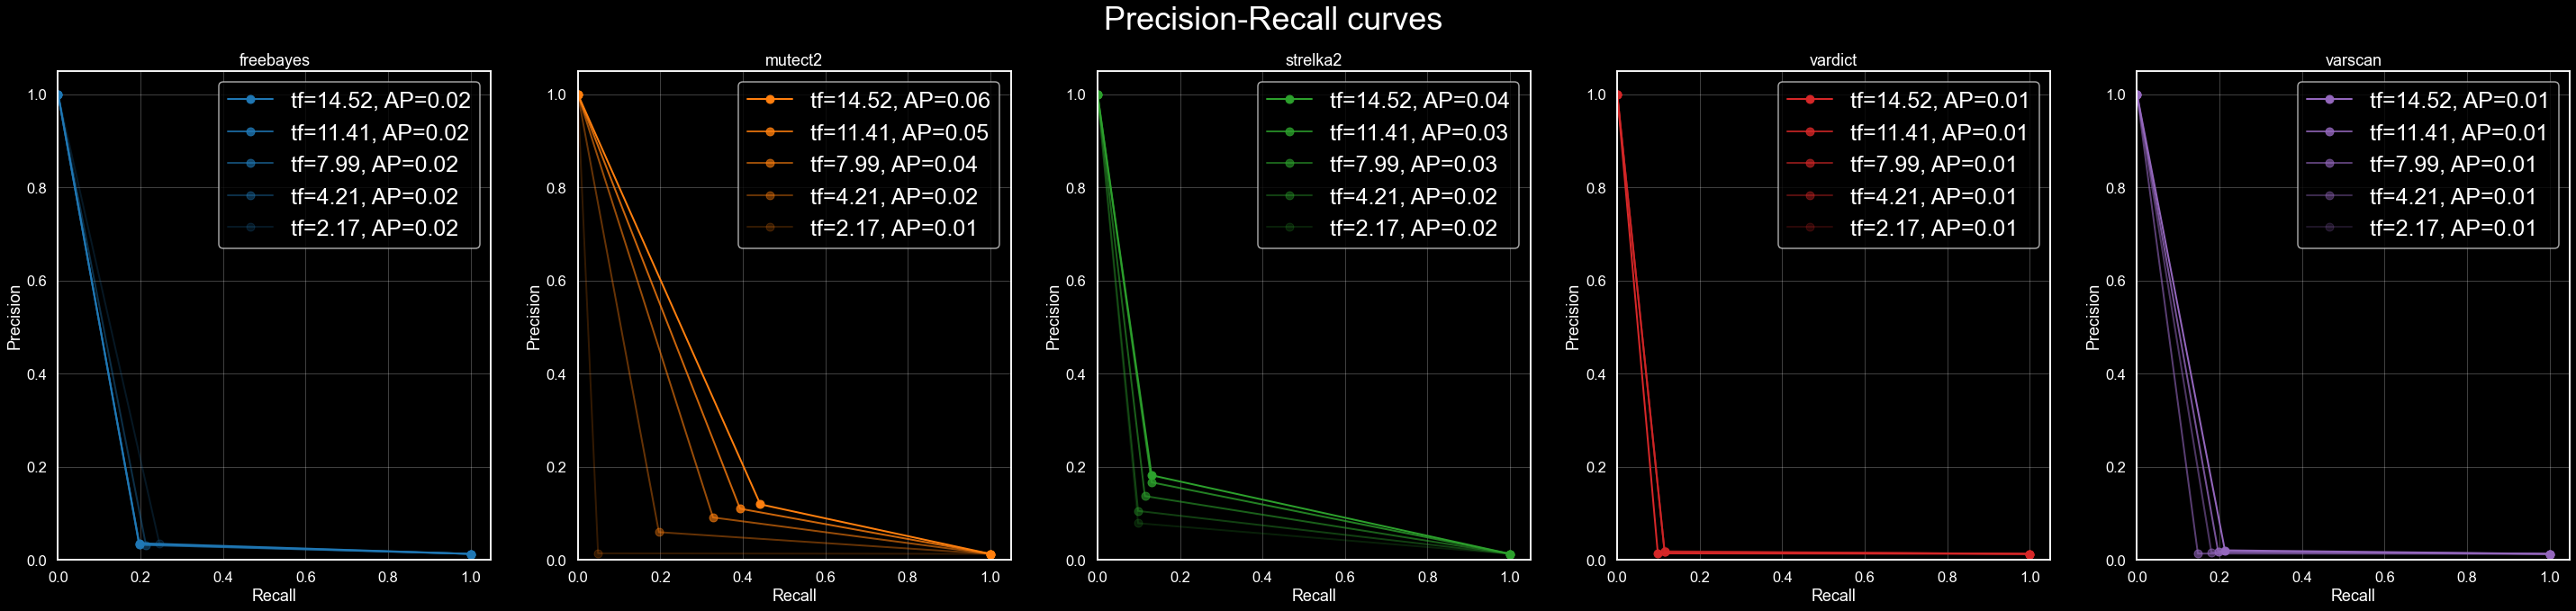

5096
(5395, 22)


<Figure size 432x288 with 0 Axes>

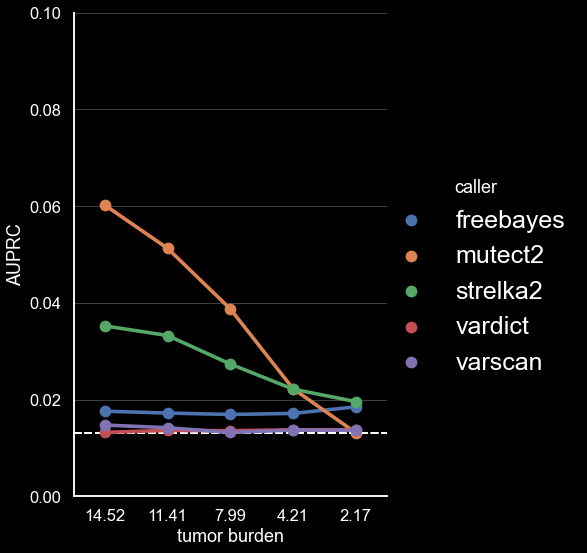

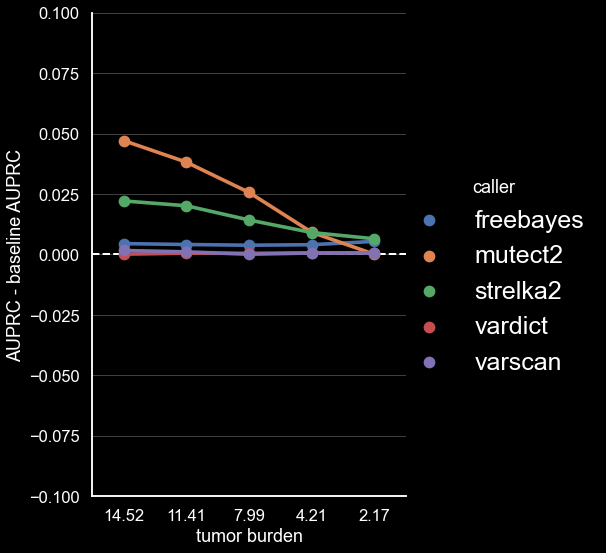

<Figure size 432x288 with 0 Axes>

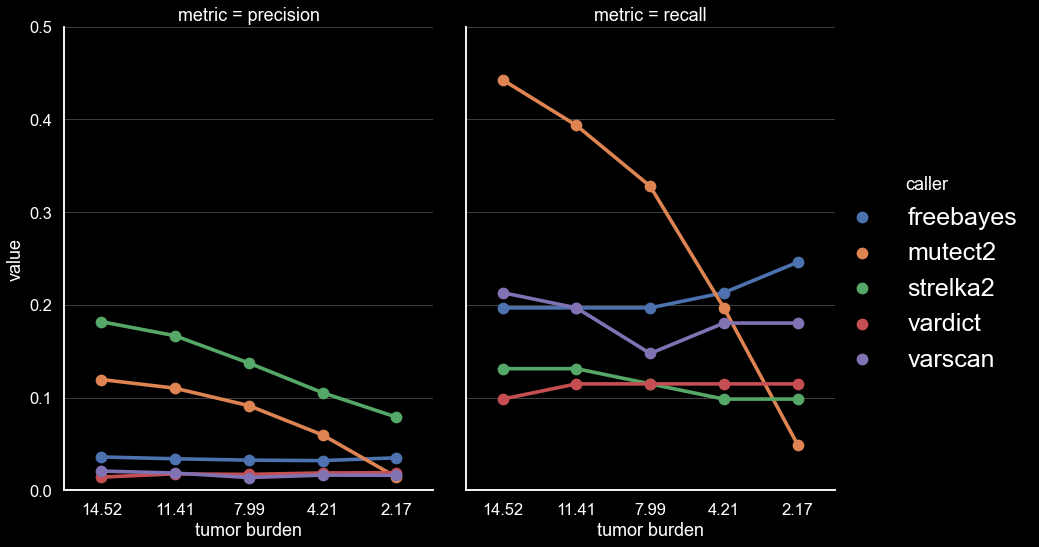

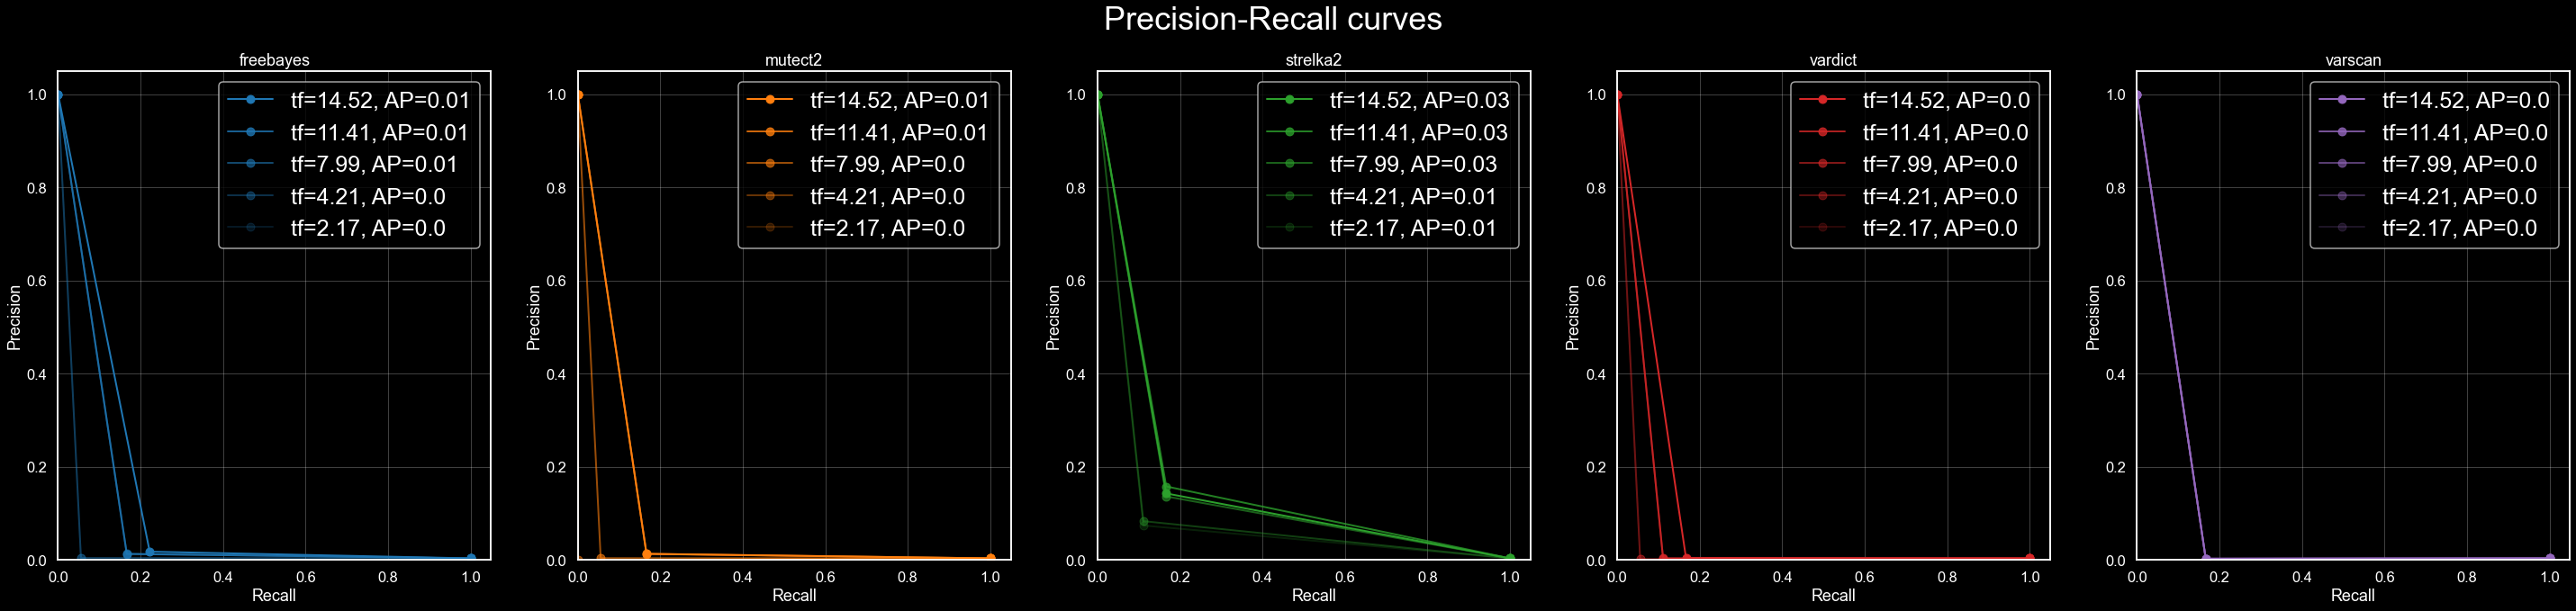

<Figure size 432x288 with 0 Axes>

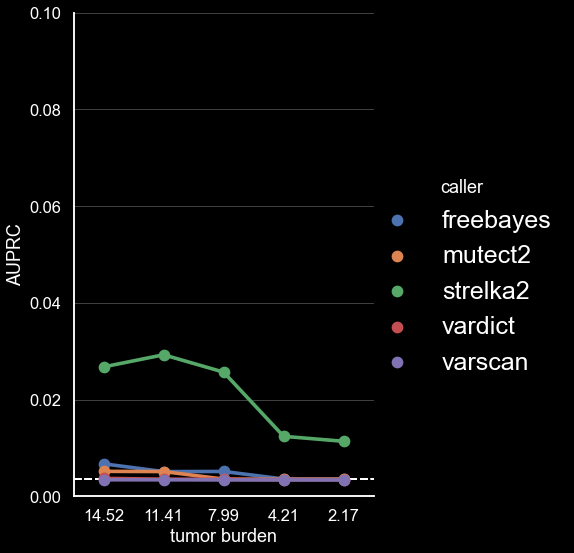

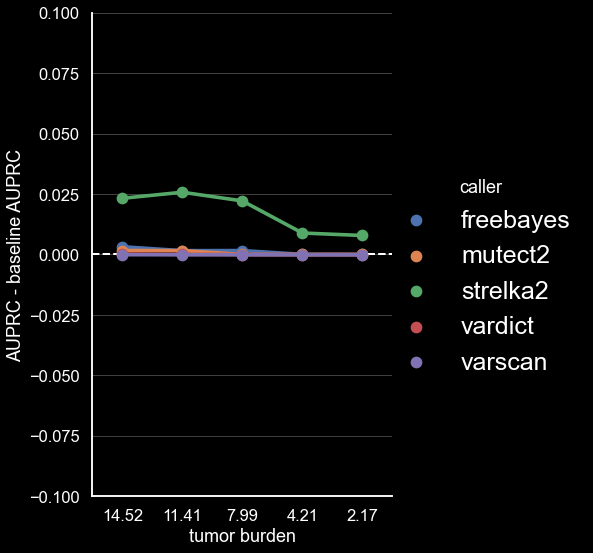

<Figure size 432x288 with 0 Axes>

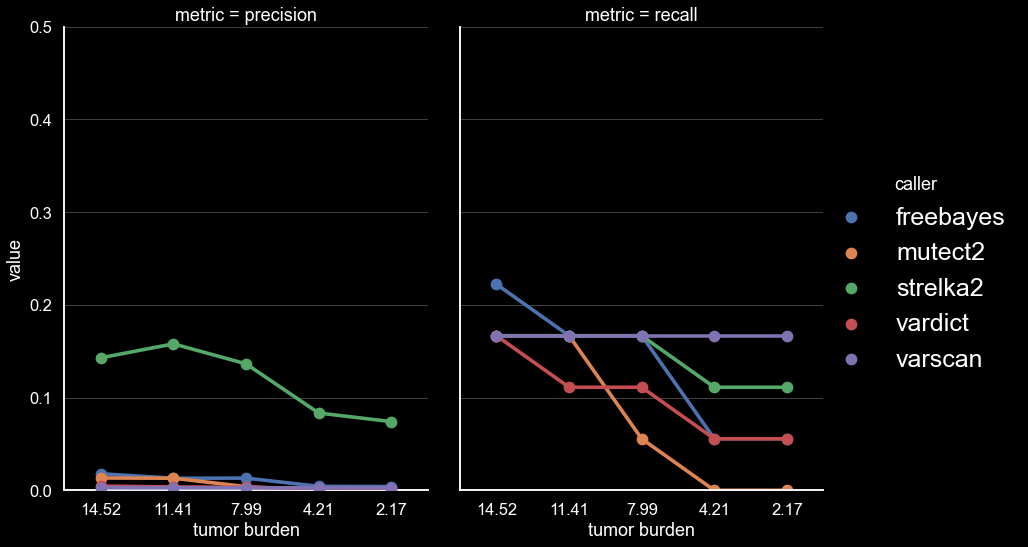

In [91]:
for mutation in ['snv', 'indel']:
    pd_methods = pd.DataFrame
    count = 0

    for mi, method in enumerate(methods):
        
        slist = []

        for i, sample in enumerate(samples):
            if i == 0:
                si = sample[['REF', 'ALT', 'QUAL', 'type', method]]
            else:
                si = sample[['QUAL', 'type', method]]
            si.rename(columns = {method:'sample_'+str(i)},  inplace = True)
            slist.append(si)

        pd_method = pd.concat([si.loc[~si.index.duplicated()] for si in slist], axis=1)

        aux = []
        for i in range(nsamples):
            aux.append('QUAL_'+str(i))
            aux.append('type_'+str(i))
            aux.append('sample_'+str(i))
        pd_method.columns = ['REF', 'ALT'] + aux
        pd_method[list(samples_dict.keys())[:nsamples]] = pd_method[list(samples_dict.keys())[:nsamples]].fillna(value=False)
        pd_method.drop(pd_method[sum(pd_method['sample_'+str(i)] for i in range(nsamples)) == False].index, axis=0, inplace=True)
        pd_method['caller'] = method
        pd_method['type'] = pd_method[['type_'+str(i) for i in range(nsamples)]].fillna('').sum(axis=1).apply(lambda x: pd.Series(x[:3]))

        if mutation == 'snv':
            pd_method = pd_method[pd_method['type'] == 'SNV']
        elif mutation == 'indel':
            pd_method = pd_method[(pd_method['type'] == 'INS') | (pd_method['type'] == 'DEL')]
                                
        if count == 0:
            pd_methods = pd_method
            count = 1
        else:
            pd_methods = pd.concat([pd_methods, pd_method], join='inner')

    pd_results = pd.DataFrame
    pd_results_PR = pd.DataFrame
    count = 0

    #fig, axs = plt.subplots(1,nmethods,figsize=(35, 5))
    fig, axs = plt.subplots(1,nmethods,figsize=(50, 10))
    fig.suptitle('Precision-Recall curves')
    
    y_true = pd_methods[['sample_0', 'caller']]
    y_true.index.name = 'CHROM_POS'
    y_true = y_true.groupby(['CHROM_POS'])['sample_0'].sum()
    y_true[y_true <= 2] = 0
    y_true = y_true.astype(bool)
    print(y_true.shape[0])
    print(pd_methods.shape)

    baselineAUPRC = {}


    for mi, method in enumerate(methods):

        res_df = (100*pd.Series(samples_tf)).round(decimals=2).to_frame(name='tumor burden')
        res_PR_df = (100*pd.Series(samples_tf)).round(decimals=2).to_frame(name='tumor burden')

        y_list = []
       # y_true = pd_methods[pd_methods['caller'] == method]['sample_0'].astype(bool)
        baselineAUPRC[method] = len(y_true[y_true == True])/len(y_true)
        for i in range(nsamples):
            y_i = pd_methods[pd_methods['caller'] == method]['sample_'+str(i)].astype(bool).reindex(y_true.index).squeeze()
            y_i = y_i.fillna(False)
            y_list.append(y_i)

        res_df['AUPRC'] = [average_precision_score(y_true, y_i) for y_i in y_list]  
        res_df['AUPRC - baseline AUPRC'] = [average_precision_score(y_true, y_i) - baselineAUPRC[method] for y_i in y_list]
        res_PR_df['precision'] = [precision_score(y_true, y_i) for y_i in y_list]
        res_PR_df['recall'] = [recall_score(y_true, y_i) for y_i in y_list]

        res_PR_df = pd.melt(res_PR_df, id_vars =['tumor burden'], value_vars =['precision', 'recall'],
                        var_name='metric', value_name='value')
        res_df['caller'] = method
        res_PR_df['caller'] = method

        res_df.drop(['sample_0'], inplace=True)
        res_PR_df.drop([0, nsamples], inplace=True)

        
        # Plot Precision-Recall curve
        for i in range(1,nsamples):
            y_i = pd_methods[pd_methods['caller'] == method]['sample_'+str(i)].astype(bool).reindex(y_true.index).squeeze()
            y_i = y_i.fillna(False)
            precision, recall, _ = precision_recall_curve(y_true, y_i)
            axs[mi].plot(recall, precision, 'o-',
                                  label='tf='+str(res_df['tumor burden'].loc['sample_'+str(i)])+ ', AP='+str(round(average_precision_score(y_true, y_i), 2)),
                                  c=color_list[mi], alpha=alpha_list[i])
        axs[mi].set_xlabel('Recall')
        axs[mi].set_ylabel('Precision')
        axs[mi].set_ylim([0.0, 1.05])
        axs[mi].set_xlim([0.0, 1.05])
        axs[mi].set_title(method)
        axs[mi].legend()

        if count == 0:
            pd_results = res_df
            pd_results_PR = res_PR_df
            count = 1
        else:
            pd_results = pd.concat([pd_results, res_df], join='inner')
            pd_results_PR = pd.concat([pd_results_PR, res_PR_df], join='inner')
    plt.show()

    plt.figure()
    sns.catplot(x="tumor burden", y="AUPRC", hue="caller",  
                    capsize=.2, height=8, aspect=.75,
                    kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results)
    for mi, method in enumerate(methods):
        plt.axhline(y = baselineAUPRC[method], color = lc, linestyle = '--') 
    plt.ylim([0, 0.1])
    
    sns.catplot(x="tumor burden", y="AUPRC - baseline AUPRC", hue="caller",  
                capsize=.2, height=8, aspect=.75,
                kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results)
    plt.axhline(y = 0, color = lc, linestyle = '--', label='baseline AUPRC') 
    plt.ylim([-0.1, 0.1])

    plt.figure()
    sns.catplot(x="tumor burden", y="value", col="metric", hue="caller",  
                    capsize=.2, height=8, aspect=.75,
                    kind="point", order=sorted(pd_results_PR['tumor burden'].unique(), reverse=True), data=pd_results_PR)
    plt.ylim([0, 0.5])

# AUPRC with reference = SNV found in both undiluted plasma samples by the same method

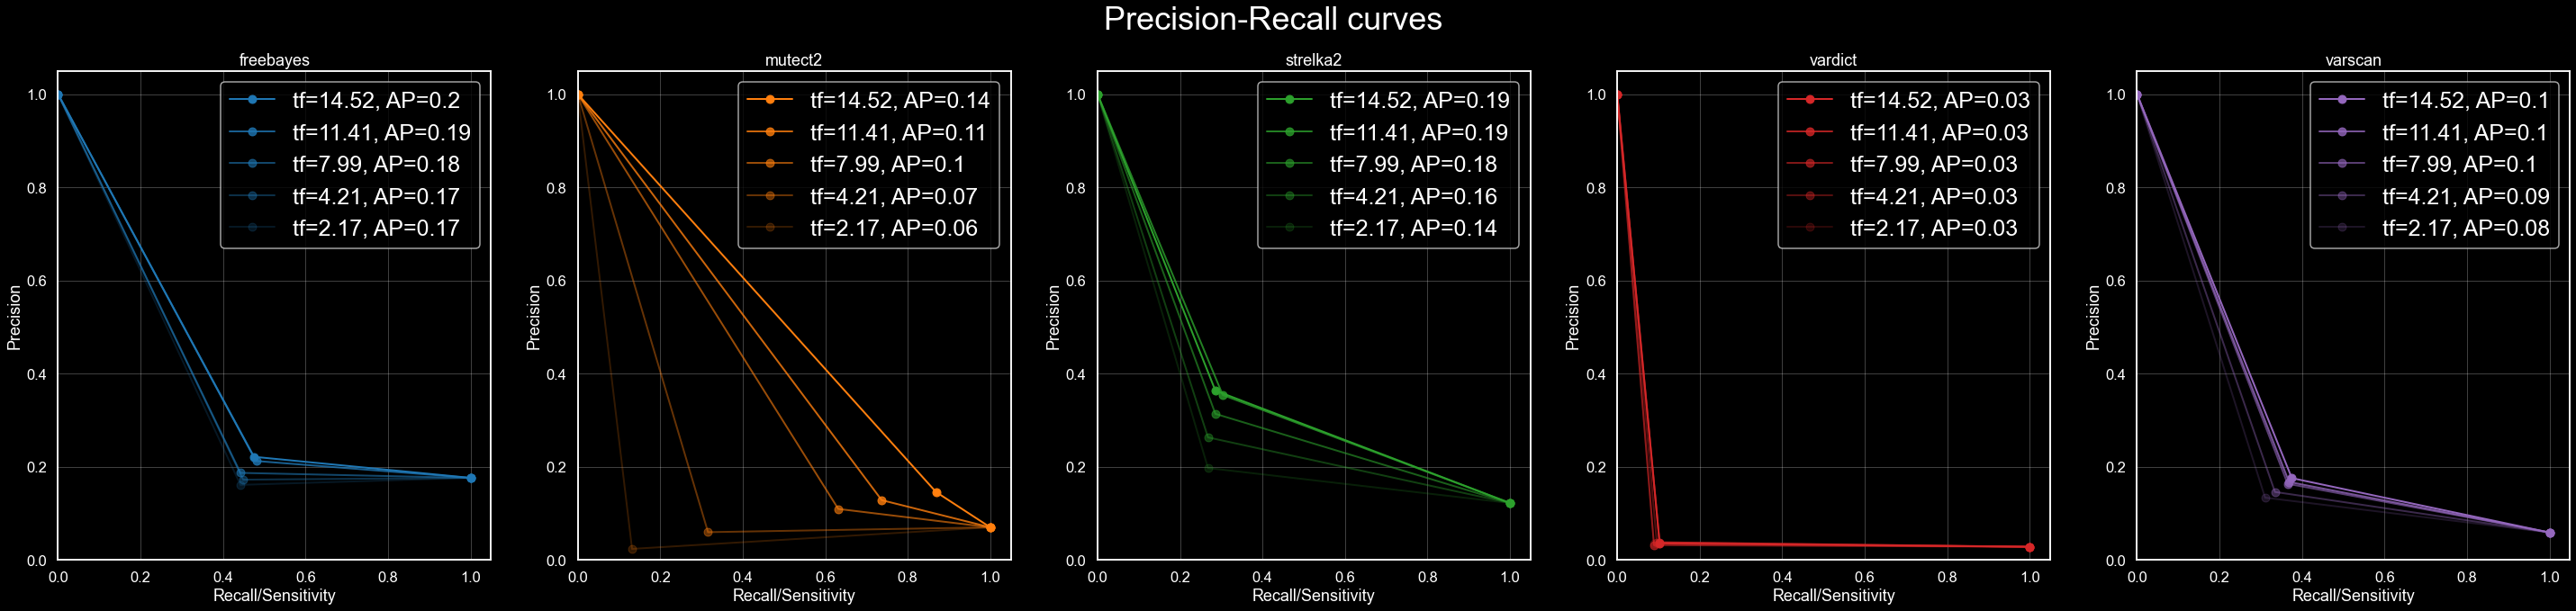

<Figure size 432x288 with 0 Axes>

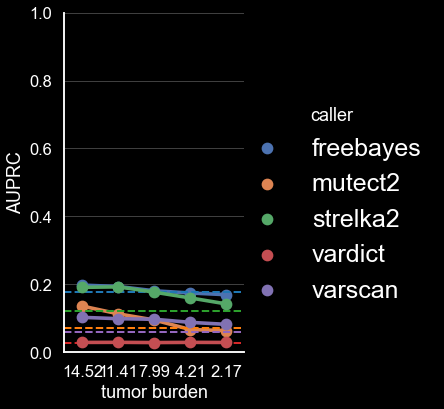

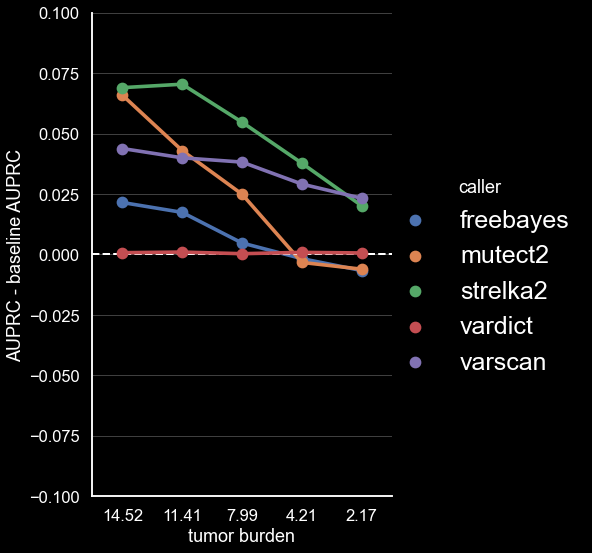

<Figure size 432x288 with 0 Axes>

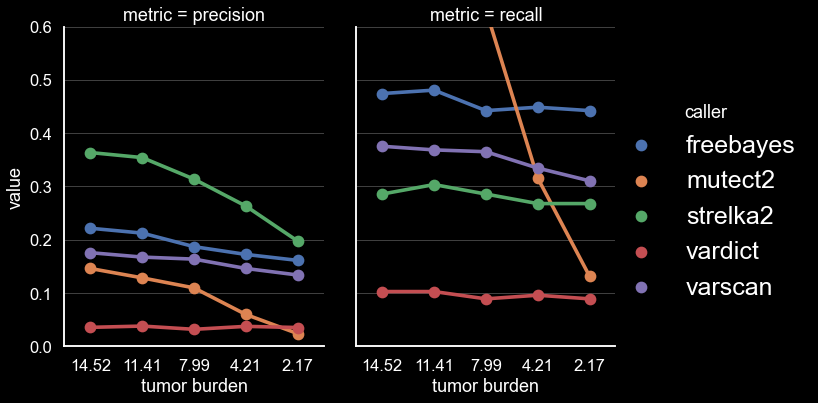

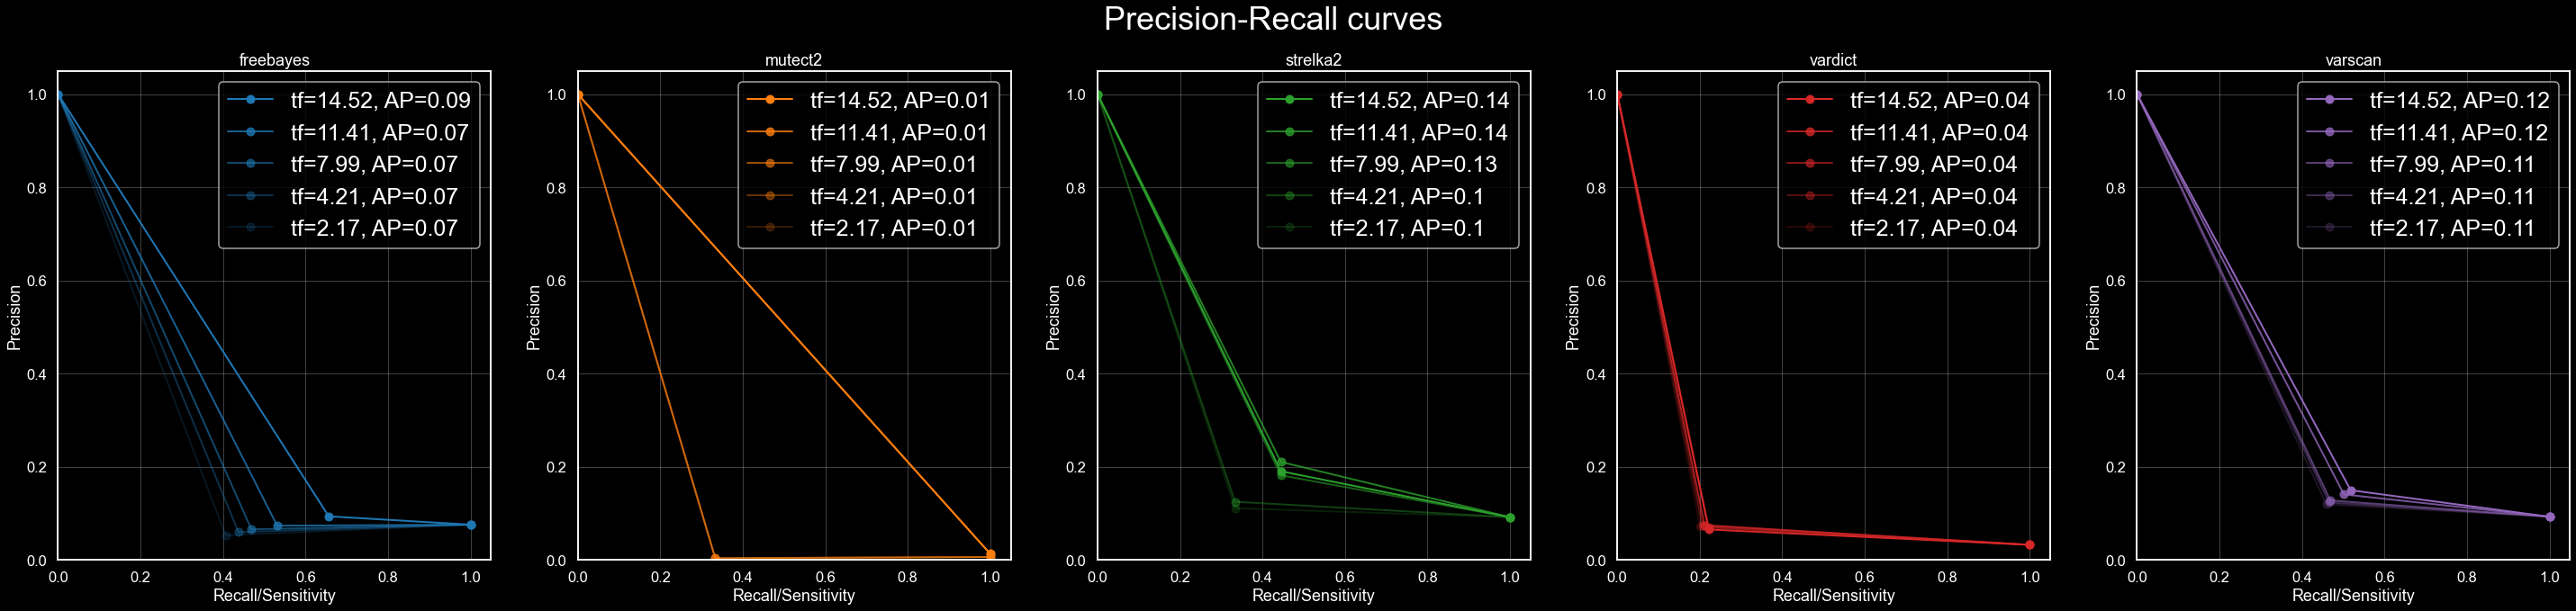

<Figure size 432x288 with 0 Axes>

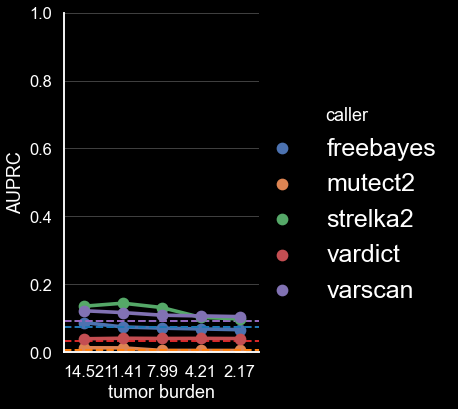

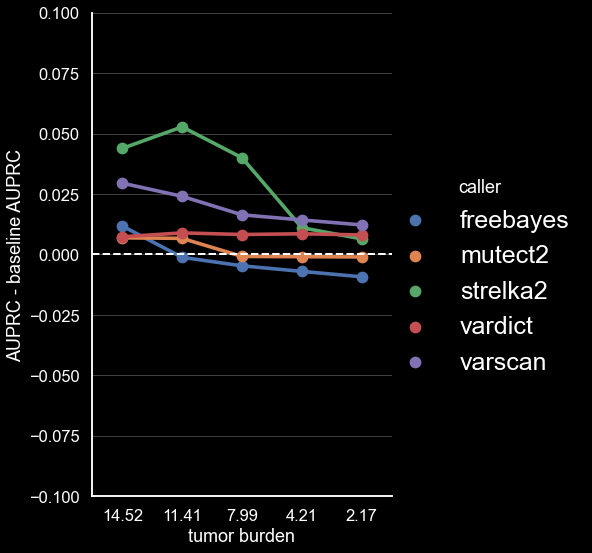

<Figure size 432x288 with 0 Axes>

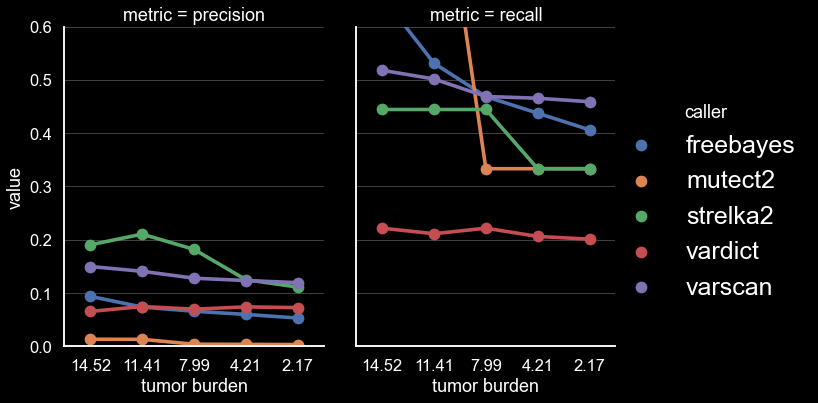

In [116]:
for mutation in ['snv', 'indel']:
    pd_methods = pd.DataFrame
    count = 0

    for mi, method in enumerate(methods):
        
        slist = []

        for i, sample in enumerate(samples):
            si = sample[['REF', 'ALT', 'QUAL', 'type', method]]
            si.rename(columns = {method:'sample_'+str(i)},  inplace = True)
            si = si.loc[~si.index.duplicated(keep=("first"))]
            slist.append(si)
        sbis = samples_dict['sample_0_bis'][['REF', 'ALT', 'QUAL', 'type', method]]
        sbis.rename(columns = {method:'sample_0_bis'},  inplace = True)
        sbis = sbis.loc[~sbis.index.duplicated(keep=("first"))]
        slist.append(sbis)
        
        pd_method = pd.concat(slist, axis=1)
        #pd_method = pd.concat([si.loc[~si.index.duplicated()] for si in slist], axis=1)
        
        pd_method['REF'] = [list(np.unique([i for i in list(ai) if str(i) != 'nan']))[-1] for ai in list(pd_method['REF'].values)]
        pd_method['ALT'] = [list(np.unique([i for i in list(ai) if str(i) != 'nan']))[-1] for ai in list(pd_method['ALT'].values)]
        pd_method = pd_method.T.drop_duplicates().T
        
        aux = []
        for i in range(nsamples):
            aux.append('QUAL_'+str(i))
            aux.append('type_'+str(i))
            aux.append('sample_'+str(i))
        aux = aux + ['QUAL_0_bis', 'type_0_bis', 'sample_0_bis']
        pd_method.columns = ['REF', 'ALT'] + aux
        pd_method[list(samples_dict.keys())[:nsamples]+['sample_0_bis']] = pd_method[list(samples_dict.keys())[:nsamples]+['sample_0_bis']].fillna(value=False)
        pd_method.drop(pd_method[sum(pd_method['sample_'+str(i)] for i in range(nsamples)) + pd_method['sample_0_bis'] == False].index, axis=0, inplace=True)
        pd_method['caller'] = method
        pd_method['type'] = pd_method[['type_'+str(i) for i in range(nsamples)] +['type_0_bis']].fillna('').sum(axis=1).apply(lambda x: pd.Series(x[:3]))

        
        if mutation == 'snv':
            pd_method = pd_method[pd_method['type'] == 'SNV']
        elif mutation == 'indel':
            pd_method = pd_method[(pd_method['type'] == 'INS') | (pd_method['type'] == 'DEL')]
                                
        if count == 0:
            pd_methods = pd_method
            count = 1
        else:
            pd_methods = pd.concat([pd_methods, pd_method], join='inner')

    pd_results = pd.DataFrame
    pd_results_PR = pd.DataFrame
    count = 0

    #fig, axs = plt.subplots(1,nmethods,figsize=(35, 5))
    fig, axs = plt.subplots(1,nmethods,figsize=(50, 10))
    fig.suptitle('Precision-Recall curves')
    

    baselineAUPRC = {}


    for mi, method in enumerate(methods):

        res_df = (100*pd.Series(samples_tf)).round(decimals=2).to_frame(name='tumor burden')
        res_PR_df = (100*pd.Series(samples_tf)).round(decimals=2).to_frame(name='tumor burden')

        y_list = []
        y_true = pd_methods[pd_methods['caller'] == method][['sample_0', 'sample_0_bis']]
        y_true['ref'] = y_true['sample_0'] & y_true['sample_0_bis']
        y_true.index.name = 'CHROM_POS'
        y_true = y_true.groupby(['CHROM_POS'])['ref'].sum()
        y_true = y_true.astype(bool)
        #y_true = pd_methods[pd_methods['caller'] == method]['sample_0'].astype(bool)
        baselineAUPRC[method] = len(y_true[y_true == True])/len(y_true)
        for i in range(nsamples):
            y_i = pd_methods[pd_methods['caller'] == method]['sample_'+str(i)].astype(bool).reindex(y_true.index).squeeze()
            y_i = y_i.fillna(False)
            y_list.append(y_i)

        res_df['AUPRC'] = [average_precision_score(y_true, y_i) for y_i in y_list]  
        res_df['AUPRC - baseline AUPRC'] = [average_precision_score(y_true, y_i) - baselineAUPRC[method] for y_i in y_list]
        res_PR_df['precision'] = [precision_score(y_true, y_i) for y_i in y_list]
        res_PR_df['recall'] = [recall_score(y_true, y_i) for y_i in y_list]

        res_PR_df = pd.melt(res_PR_df, id_vars =['tumor burden'], value_vars =['precision', 'recall'],
                        var_name='metric', value_name='value')
        res_df['caller'] = method
        res_PR_df['caller'] = method

        res_df.drop(['sample_0'], inplace=True)
        res_PR_df.drop([0, nsamples], inplace=True)

        
        # Plot Precision-Recall curve
        for i in range(1,nsamples):
            y_i = pd_methods[pd_methods['caller'] == method]['sample_'+str(i)].astype(bool).reindex(y_true.index).squeeze()
            y_i = y_i.fillna(False)
            precision, recall, _ = precision_recall_curve(y_true, y_i)
            axs[mi].plot(recall, precision, 'o-',
                                  label='tf='+str(res_df['tumor burden'].loc['sample_'+str(i)])+ ', AP='+str(round(average_precision_score(y_true, y_i), 2)),
                                  c=color_list[mi], alpha=alpha_list[i])
        axs[mi].set_xlabel('Recall/Sensitivity')
        axs[mi].set_ylabel('Precision')
        axs[mi].set_ylim([0.0, 1.05])
        axs[mi].set_xlim([0.0, 1.05])
        axs[mi].set_title(method)
        axs[mi].legend()

        if count == 0:
            pd_results = res_df
            pd_results_PR = res_PR_df
            count = 1
        else:
            pd_results = pd.concat([pd_results, res_df], join='inner')
            pd_results_PR = pd.concat([pd_results_PR, res_PR_df], join='inner')
    plt.show()

    plt.figure()
    sns.catplot(x="tumor burden", y="AUPRC", hue="caller",  
                    capsize=.2, height=6, aspect=.75,
                    kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results)
    for mi, method in enumerate(methods):
        plt.axhline(y = baselineAUPRC[method], color = color_list[mi], linestyle = '--') 
    plt.ylim([0, 1])
    
    sns.catplot(x="tumor burden", y="AUPRC - baseline AUPRC", hue="caller",  
                capsize=.2, height=8, aspect=.75,
                kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results)
    plt.axhline(y = 0, color = lc, linestyle = '--', label='baseline AUPRC') 
    plt.ylim([-0.1, 0.1])

    plt.figure()
    sns.catplot(x="tumor burden", y="value", col="metric", hue="caller",  
                    capsize=.2, height=6, aspect=.75,
                    kind="point", order=sorted(pd_results_PR['tumor burden'].unique(), reverse=True), data=pd_results_PR)
    plt.ylim([0, 0.6])

# AUPRC with reference = SNV found in both undiluted plasma samples by at least 2 callers

10965
(11997, 25)


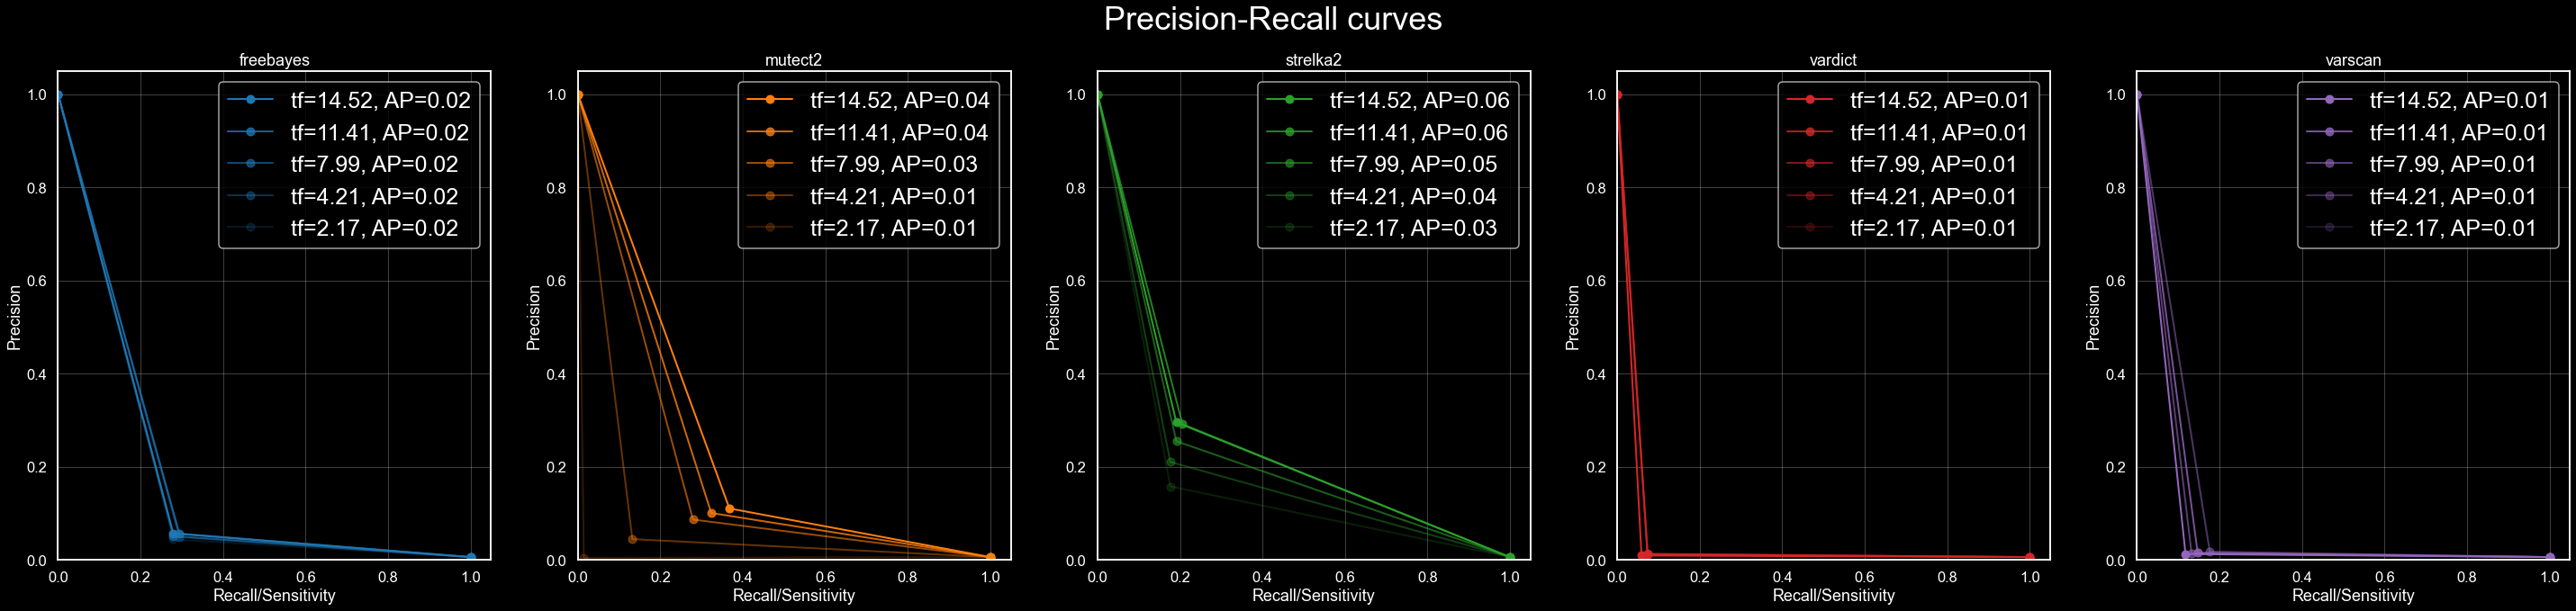

9656
(10245, 25)


<Figure size 432x288 with 0 Axes>

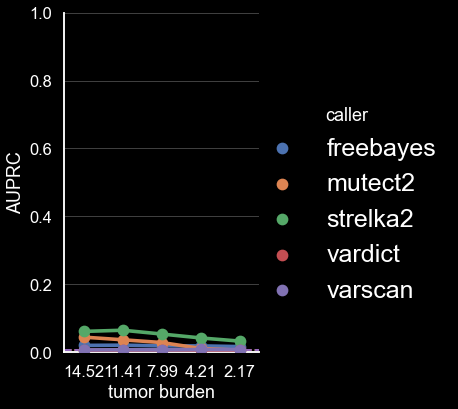

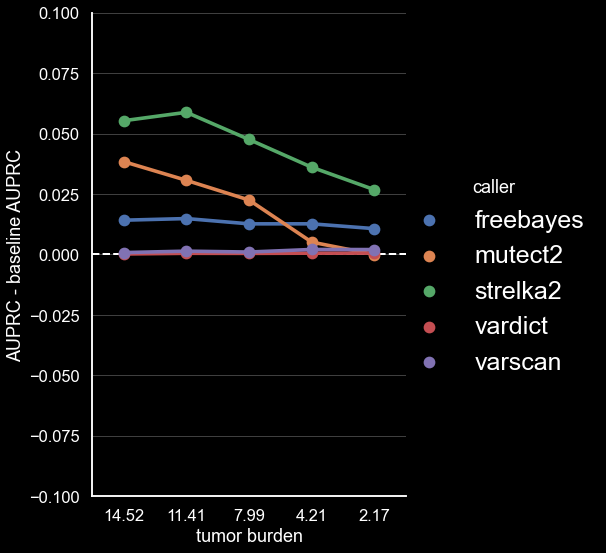

<Figure size 432x288 with 0 Axes>

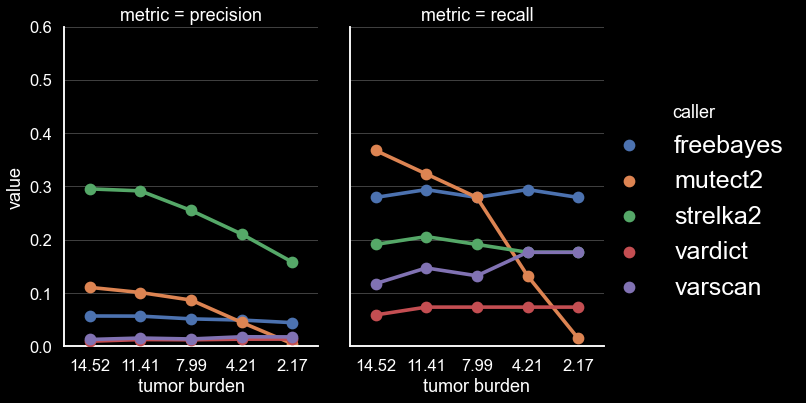

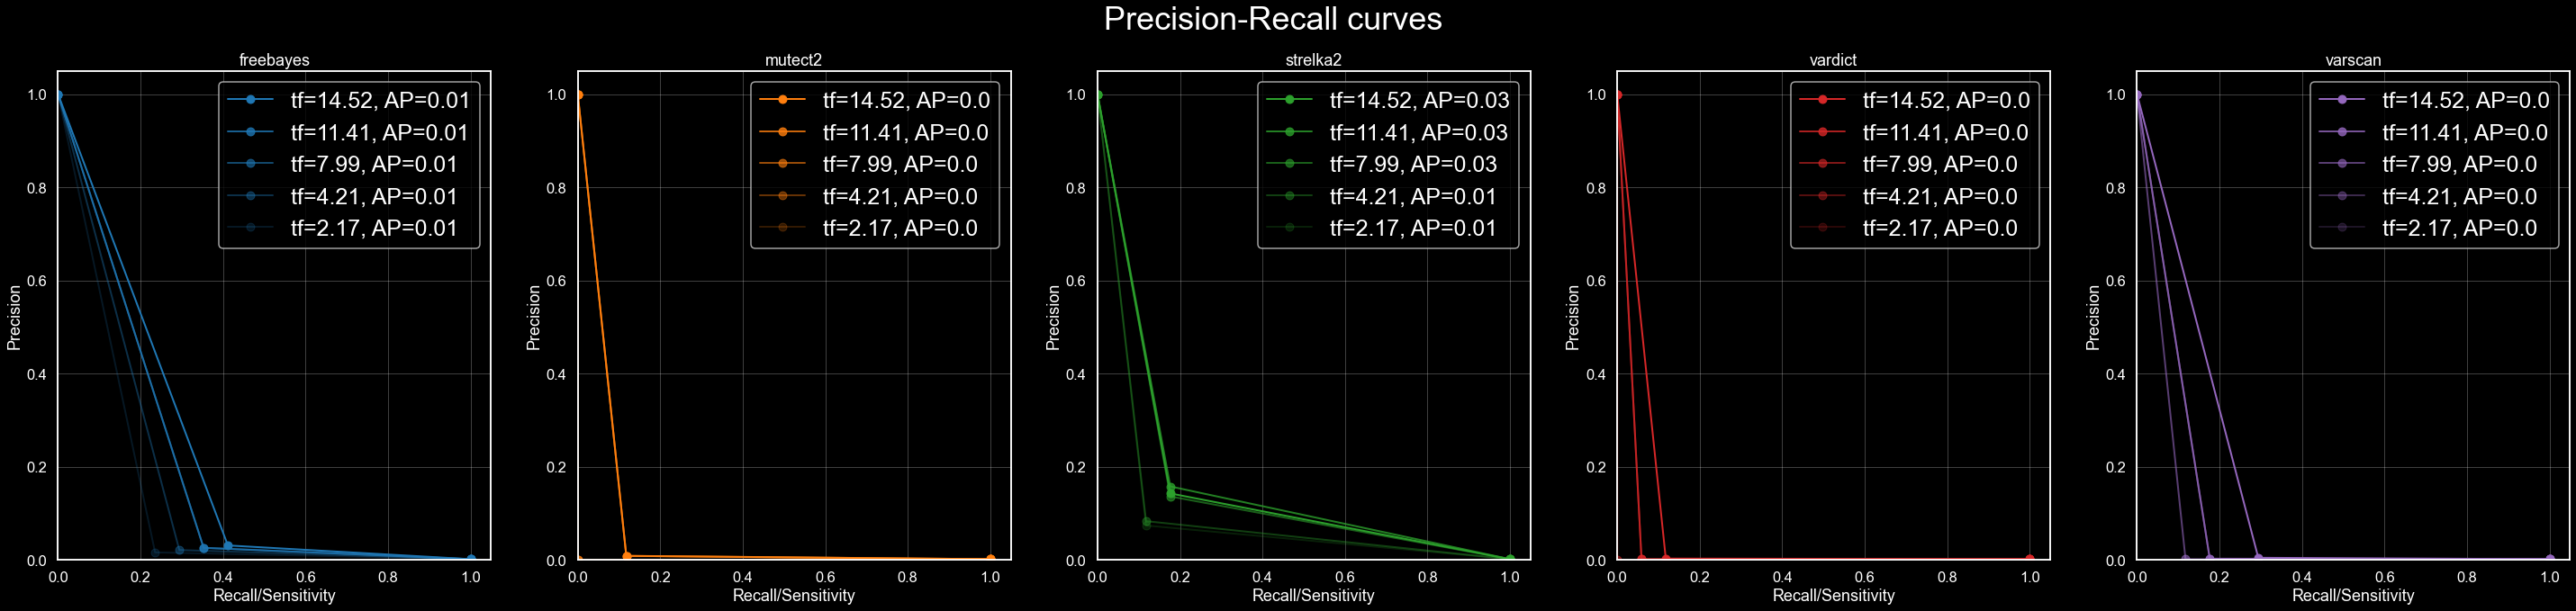

<Figure size 432x288 with 0 Axes>

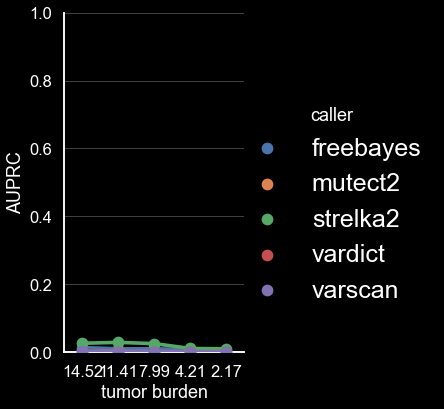

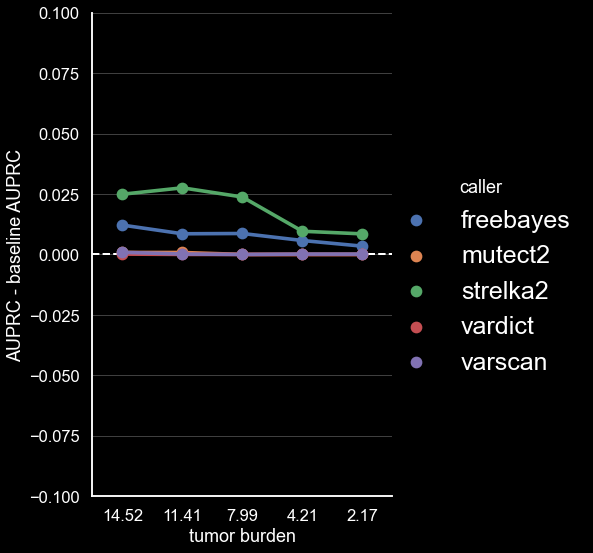

<Figure size 432x288 with 0 Axes>

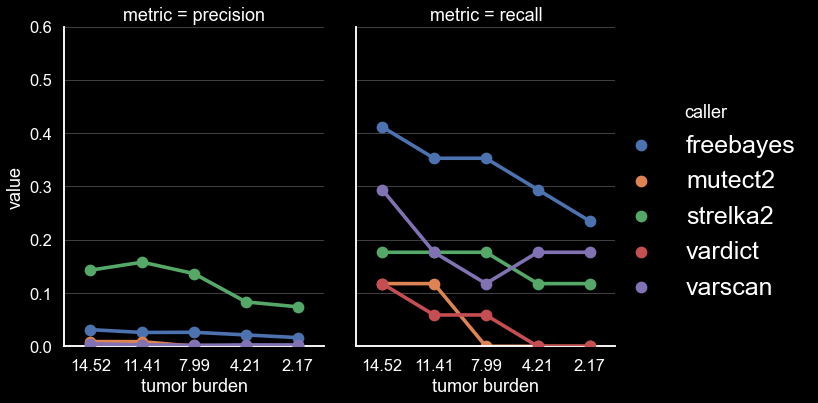

In [117]:
for mutation in ['snv', 'indel']:
    pd_methods = pd.DataFrame
    count = 0

    for mi, method in enumerate(methods):
        
        slist = []

        for i, sample in enumerate(samples):
            si = sample[['REF', 'ALT', 'QUAL', 'type', method]]
            si.rename(columns = {method:'sample_'+str(i)},  inplace = True)
            si = si.loc[~si.index.duplicated(keep=("first"))]
            slist.append(si)
        sbis = samples_dict['sample_0_bis'][['REF', 'ALT', 'QUAL', 'type', method]]
        sbis.rename(columns = {method:'sample_0_bis'},  inplace = True)
        sbis = sbis.loc[~sbis.index.duplicated(keep=("first"))]
        slist.append(sbis)
        
        pd_method = pd.concat(slist, axis=1)
        #pd_method = pd.concat([si.loc[~si.index.duplicated()] for si in slist], axis=1)
        
        pd_method['REF'] = [list(np.unique([i for i in list(ai) if str(i) != 'nan']))[-1] for ai in list(pd_method['REF'].values)]
        pd_method['ALT'] = [list(np.unique([i for i in list(ai) if str(i) != 'nan']))[-1] for ai in list(pd_method['ALT'].values)]
        pd_method = pd_method.T.drop_duplicates().T
        
        aux = []
        for i in range(nsamples):
            aux.append('QUAL_'+str(i))
            aux.append('type_'+str(i))
            aux.append('sample_'+str(i))
        aux = aux + ['QUAL_0_bis', 'type_0_bis', 'sample_0_bis']
        pd_method.columns = ['REF', 'ALT'] + aux
        pd_method[list(samples_dict.keys())[:nsamples]+['sample_0_bis']] = pd_method[list(samples_dict.keys())[:nsamples]+['sample_0_bis']].fillna(value=False)
        pd_method.drop(pd_method[sum(pd_method['sample_'+str(i)] for i in range(nsamples)) + pd_method['sample_0_bis'] == False].index, axis=0, inplace=True)
        pd_method['caller'] = method
        pd_method['type'] = pd_method[['type_'+str(i) for i in range(nsamples)] +['type_0_bis']].fillna('').sum(axis=1).apply(lambda x: pd.Series(x[:3]))

        
        if mutation == 'snv':
            pd_method = pd_method[pd_method['type'] == 'SNV']
        elif mutation == 'indel':
            pd_method = pd_method[(pd_method['type'] == 'INS') | (pd_method['type'] == 'DEL')]
                                
        if count == 0:
            pd_methods = pd_method
            count = 1
        else:
            pd_methods = pd.concat([pd_methods, pd_method], join='inner')

    pd_results = pd.DataFrame
    pd_results_PR = pd.DataFrame
    count = 0

    #fig, axs = plt.subplots(1,nmethods,figsize=(35, 5))
    fig, axs = plt.subplots(1,nmethods,figsize=(50, 10))
    fig.suptitle('Precision-Recall curves')
    
    y_true = pd_methods[['sample_0', 'sample_0_bis', 'caller']]
    y_true['ref'] = pd_methods['sample_0'] & pd_methods['sample_0_bis']
    y_true.index.name = 'CHROM_POS'
    y_true = y_true.groupby(['CHROM_POS'])['ref'].sum()
    y_true[y_true <= 1] = 0
    y_true = y_true.astype(bool)
    print(y_true.shape[0])
    print(pd_methods.shape)
    

    baselineAUPRC = {}


    for mi, method in enumerate(methods):

        res_df = (100*pd.Series(samples_tf)).round(decimals=2).to_frame(name='tumor burden')
        res_PR_df = (100*pd.Series(samples_tf)).round(decimals=2).to_frame(name='tumor burden')

        y_list = []
        #y_true = pd_methods[pd_methods['caller'] == method]['sample_0'].astype(bool)
        baselineAUPRC[method] = len(y_true[y_true == True])/len(y_true)
        for i in range(nsamples):
            y_i = pd_methods[pd_methods['caller'] == method]['sample_'+str(i)].astype(bool).reindex(y_true.index).squeeze()
            y_i = y_i.fillna(False)
            y_list.append(y_i)

        res_df['AUPRC'] = [average_precision_score(y_true, y_i) for y_i in y_list]  
        res_df['AUPRC - baseline AUPRC'] = [average_precision_score(y_true, y_i) - baselineAUPRC[method] for y_i in y_list]
        res_PR_df['precision'] = [precision_score(y_true, y_i) for y_i in y_list]
        res_PR_df['recall'] = [recall_score(y_true, y_i) for y_i in y_list]

        res_PR_df = pd.melt(res_PR_df, id_vars =['tumor burden'], value_vars =['precision', 'recall'],
                        var_name='metric', value_name='value')
        res_df['caller'] = method
        res_PR_df['caller'] = method

        res_df.drop(['sample_0'], inplace=True)
        res_PR_df.drop([0, nsamples], inplace=True)

        
        # Plot Precision-Recall curve
        for i in range(1,nsamples):
            y_i = pd_methods[pd_methods['caller'] == method]['sample_'+str(i)].astype(bool).reindex(y_true.index).squeeze()
            y_i = y_i.fillna(False)
            precision, recall, _ = precision_recall_curve(y_true, y_i)
            axs[mi].plot(recall, precision, 'o-',
                                  label='tf='+str(res_df['tumor burden'].loc['sample_'+str(i)])+ ', AP='+str(round(average_precision_score(y_true, y_i), 2)),
                                  c=color_list[mi], alpha=alpha_list[i])
        axs[mi].set_xlabel('Recall/Sensitivity')
        axs[mi].set_ylabel('Precision')
        axs[mi].set_ylim([0.0, 1.05])
        axs[mi].set_xlim([0.0, 1.05])
        axs[mi].set_title(method)
        axs[mi].legend()

        if count == 0:
            pd_results = res_df
            pd_results_PR = res_PR_df
            count = 1
        else:
            pd_results = pd.concat([pd_results, res_df], join='inner')
            pd_results_PR = pd.concat([pd_results_PR, res_PR_df], join='inner')
    plt.show()

    plt.figure()
    sns.catplot(x="tumor burden", y="AUPRC", hue="caller",  
                    capsize=.2, height=6, aspect=.75,
                    kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results)
    for mi, method in enumerate(methods):
        plt.axhline(y = baselineAUPRC[method], color = color_list[mi], linestyle = '--') 
    plt.ylim([0, 1])
    
    sns.catplot(x="tumor burden", y="AUPRC - baseline AUPRC", hue="caller",  
                capsize=.2, height=8, aspect=.75,
                kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results)
    plt.axhline(y = 0, color = lc, linestyle = '--', label='baseline AUPRC') 
    plt.ylim([-0.1, 0.1])

    plt.figure()
    sns.catplot(x="tumor burden", y="value", col="metric", hue="caller",  
                    capsize=.2, height=6, aspect=.75,
                    kind="point", order=sorted(pd_results_PR['tumor burden'].unique(), reverse=True), data=pd_results_PR)
    plt.ylim([0, 0.6])

## AUPRC with reference = SNV found in the tumor by the same method

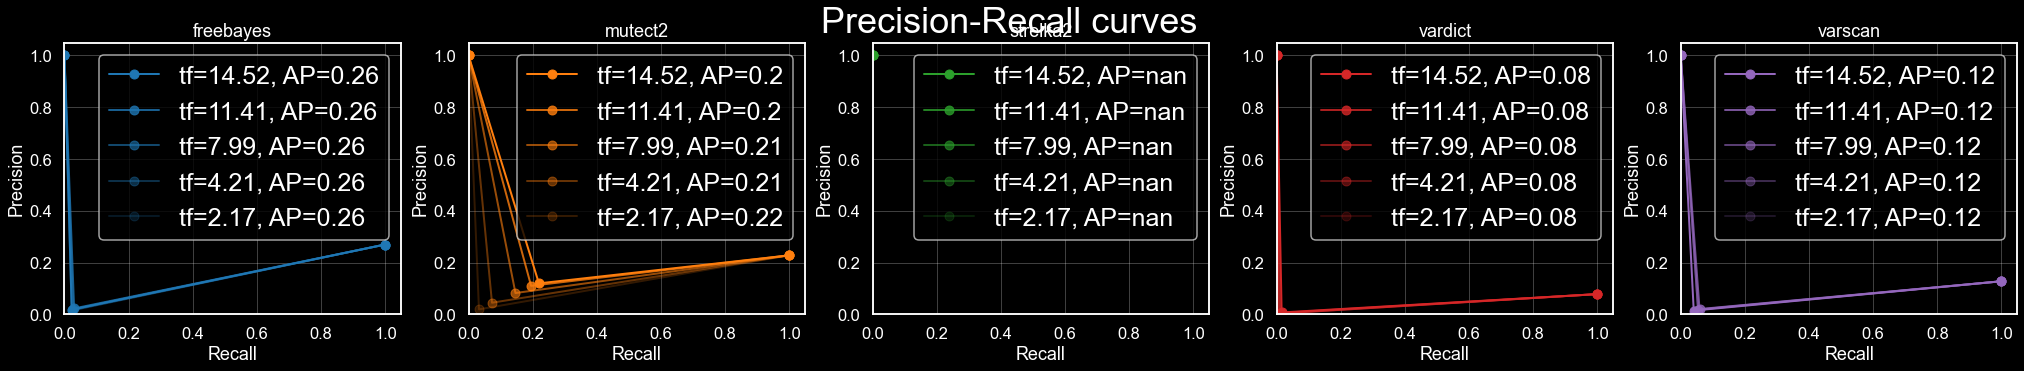

<Figure size 432x288 with 0 Axes>

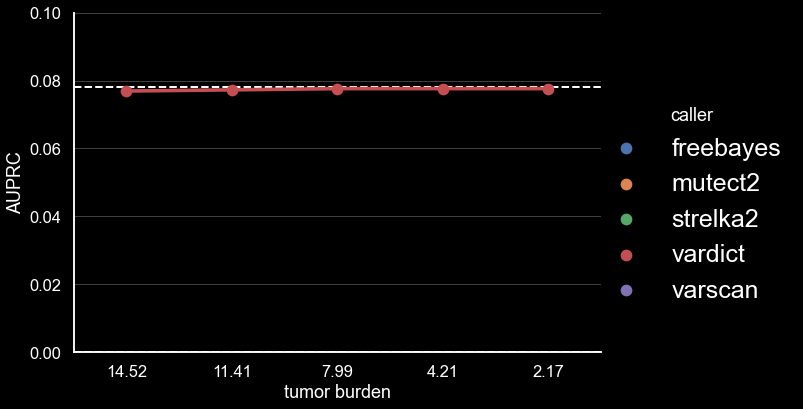

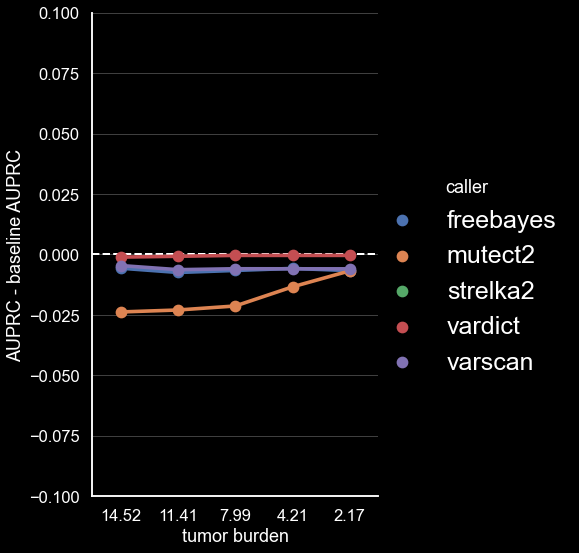

<Figure size 432x288 with 0 Axes>

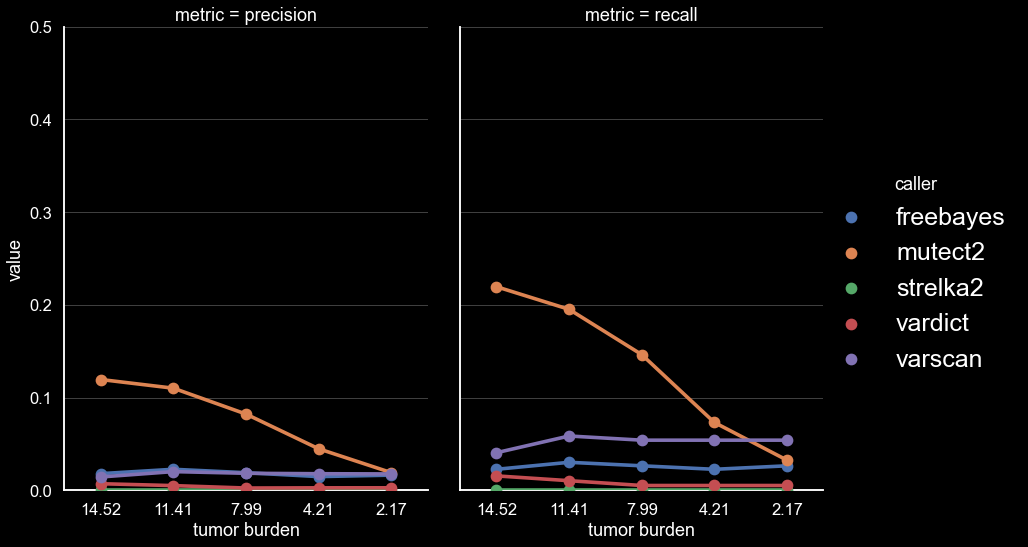

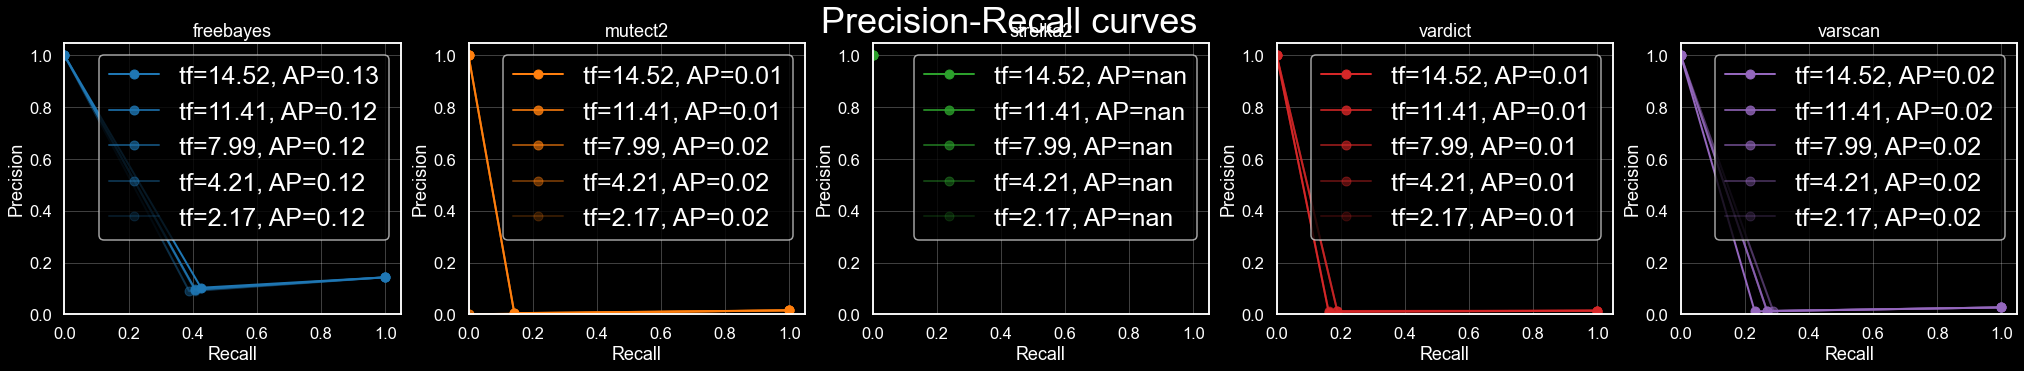

<Figure size 432x288 with 0 Axes>

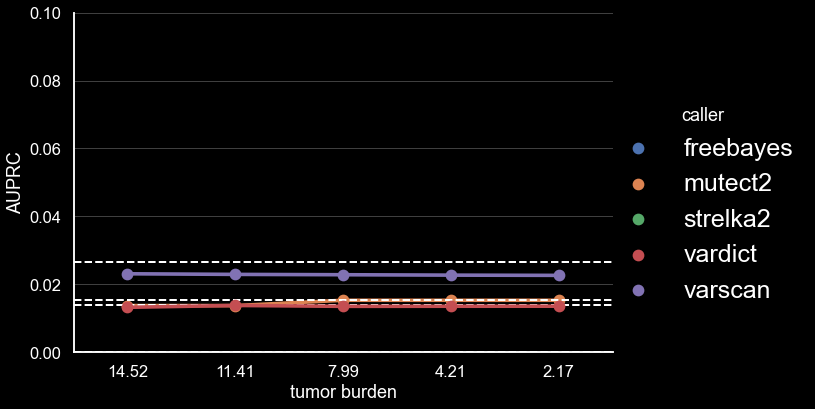

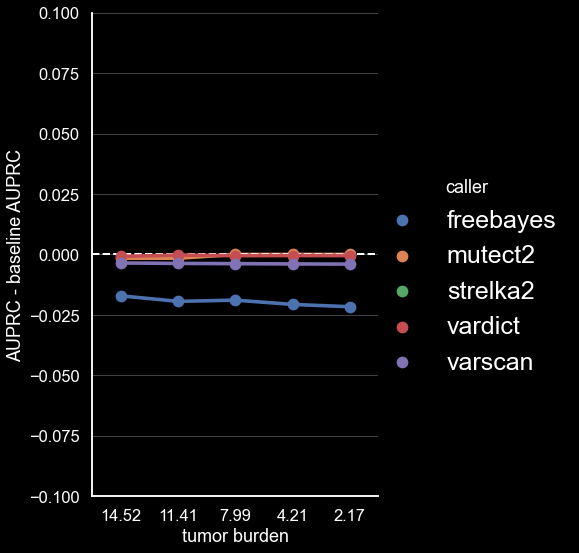

<Figure size 432x288 with 0 Axes>

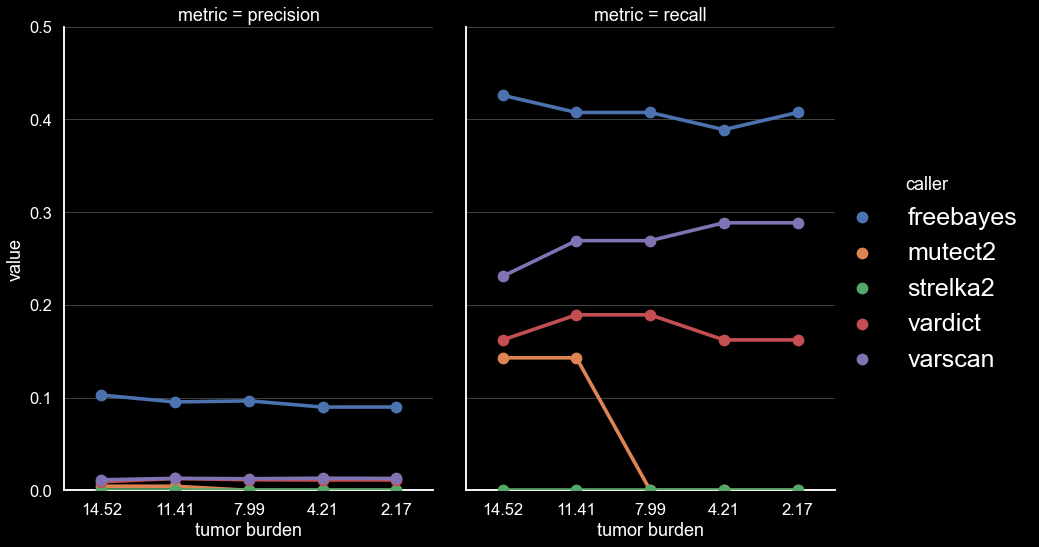

In [120]:
for mutation in ['snv', 'indel']:
    pd_methods = pd.DataFrame
    count = 0

    for mi, method in enumerate(methods):
        
        slist = []

        for i, sample in enumerate(samples):
            si = sample[['REF', 'ALT', 'QUAL', 'type', method]]
            si.rename(columns = {method:'sample_'+str(i)},  inplace = True)
            si = si.loc[~si.index.duplicated(keep=("first"))]
            slist.append(si)
        st = samples_dict['sample_t'][['REF', 'ALT', 'QUAL', 'type', method]]
        st.rename(columns = {method:'sample_t'},  inplace = True)
        st = st.loc[~st.index.duplicated(keep=("first"))]
        slist.append(st)

        pd_method = pd.concat(slist, axis=1)
        #pd_method = pd.concat([si.loc[~si.index.duplicated()] for si in slist], axis=1)
        
        pd_method['REF'] = [list(np.unique([i for i in list(ai) if str(i) != 'nan']))[-1] for ai in list(pd_method['REF'].values)]
        pd_method['ALT'] = [list(np.unique([i for i in list(ai) if str(i) != 'nan']))[-1] for ai in list(pd_method['ALT'].values)]
        pd_method = pd_method.T.drop_duplicates().T

        aux = []
        for i in range(nsamples):
            aux.append('QUAL_'+str(i))
            aux.append('type_'+str(i))
            aux.append('sample_'+str(i))
        aux = aux + ['QUAL_t', 'type_t', 'sample_t']
        pd_method.columns = ['REF', 'ALT'] + aux
        pd_method[list(samples_dict.keys())[:nsamples]+['sample_t']] = pd_method[list(samples_dict.keys())[:nsamples]+['sample_t']].fillna(value=False)
        pd_method.drop(pd_method[sum(pd_method['sample_'+str(i)] for i in range(nsamples)) + pd_method['sample_t'] == False].index, axis=0, inplace=True)
        pd_method['caller'] = method
        pd_method['type'] = pd_method[['type_'+str(i) for i in range(nsamples)] +['type_t']].fillna('').sum(axis=1).apply(lambda x: pd.Series(x[:3]))

        if mutation == 'snv':
            pd_method = pd_method[pd_method['type'] == 'SNV']
        elif mutation == 'indel':
            pd_method = pd_method[(pd_method['type'] == 'INS') | (pd_method['type'] == 'DEL')]
                                
        if count == 0:
            pd_methods = pd_method
            count = 1
        else:
            pd_methods = pd.concat([pd_methods, pd_method], join='inner')

    pd_results = pd.DataFrame
    pd_results_PR = pd.DataFrame
    count = 0

    fig, axs = plt.subplots(1,nmethods,figsize=(35, 5))
    fig.suptitle('Precision-Recall curves')
    

    baselineAUPRC = {}


    for mi, method in enumerate(methods):

        res_df = (100*pd.Series(samples_tf)).round(decimals=2).to_frame(name='tumor burden')
        res_PR_df = (100*pd.Series(samples_tf)).round(decimals=2).to_frame(name='tumor burden')

        y_list = []
        y_true = pd_methods[pd_methods['caller'] == method]['sample_t'].astype(bool)
        baselineAUPRC[method] = len(y_true[y_true == True])/len(y_true)
        for i in range(nsamples):
            y_i = pd_methods[pd_methods['caller'] == method]['sample_'+str(i)].astype(bool).reindex(y_true.index).squeeze()
            y_i = y_i.fillna(False)
            y_list.append(y_i)

        res_df['AUPRC'] = [average_precision_score(y_true, y_i) for y_i in y_list]  
        res_df['AUPRC - baseline AUPRC'] = [average_precision_score(y_true, y_i) - baselineAUPRC[method] for y_i in y_list]
        res_PR_df['precision'] = [precision_score(y_true, y_i) for y_i in y_list]
        res_PR_df['recall'] = [recall_score(y_true, y_i) for y_i in y_list]

        res_PR_df = pd.melt(res_PR_df, id_vars =['tumor burden'], value_vars =['precision', 'recall'],
                        var_name='metric', value_name='value')
        res_df['caller'] = method
        res_PR_df['caller'] = method

        res_df.drop(['sample_0'], inplace=True)
        res_PR_df.drop([0, nsamples], inplace=True)

        
        # Plot Precision-Recall curve
        for i in range(1,nsamples):
            y_i = pd_methods[pd_methods['caller'] == method]['sample_'+str(i)].astype(bool).reindex(y_true.index).squeeze()
            y_i = y_i.fillna(False)
            precision, recall, _ = precision_recall_curve(y_true, y_i)
            axs[mi].plot(recall, precision, 'o-',
                                  label='tf='+str(res_df['tumor burden'].loc['sample_'+str(i)])+ ', AP='+str(round(average_precision_score(y_true, y_i), 2)),
                                  c=color_list[mi], alpha=alpha_list[i])
        axs[mi].set_xlabel('Recall')
        axs[mi].set_ylabel('Precision')
        axs[mi].set_ylim([0.0, 1.05])
        axs[mi].set_xlim([0.0, 1.05])
        axs[mi].set_title(method)
        axs[mi].legend()

        if count == 0:
            pd_results = res_df
            pd_results_PR = res_PR_df
            count = 1
        else:
            pd_results = pd.concat([pd_results, res_df], join='inner')
            pd_results_PR = pd.concat([pd_results_PR, res_PR_df], join='inner')
    plt.show()

    plt.figure()
    sns.catplot(x="tumor burden", y="AUPRC", hue="caller",  
                    capsize=.2, height=6, aspect=1.5,
                    kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results)
    for mi, method in enumerate(methods):
        plt.axhline(y = baselineAUPRC[method], color = lc, linestyle = '--') 
    plt.ylim([0, 0.1])
    
    sns.catplot(x="tumor burden", y="AUPRC - baseline AUPRC", hue="caller",  
                capsize=.2, height=8, aspect=.75,
                kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results)
    plt.axhline(y = 0, color = lc, linestyle = '--', label='baseline AUPRC') 
    plt.ylim([-0.1, 0.1])

    plt.figure()
    sns.catplot(x="tumor burden", y="value", col="metric", hue="caller",  
                    capsize=.2, height=8, aspect=.75,
                    kind="point", order=sorted(pd_results_PR['tumor burden'].unique(), reverse=True), data=pd_results_PR)
    plt.ylim([0, 0.5])

4933


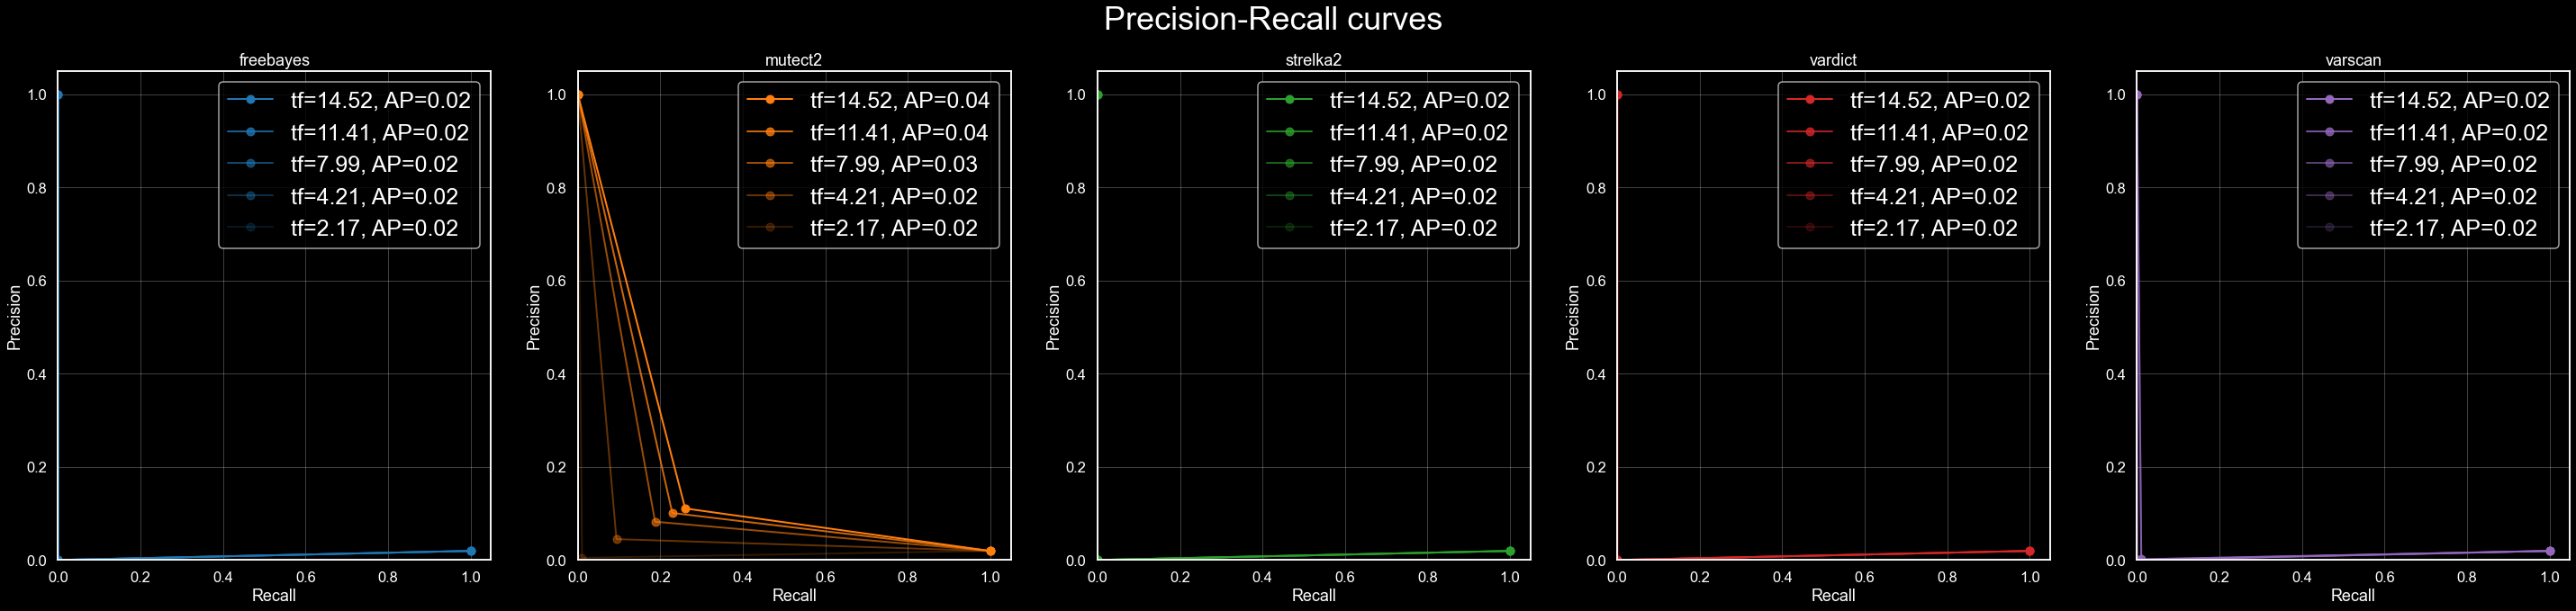

In [ ]:
for mutation in ['snv', 'indel']:
    pd_methods = pd.DataFrame
    count = 0

    for mi, method in enumerate(methods):
        
        slist = []

        for i, sample in enumerate(samples):
            si = sample[['REF', 'ALT', 'QUAL', 'type', method]]
            si.rename(columns = {method:'sample_'+str(i)},  inplace = True)
            si = si.loc[~si.index.duplicated(keep=("first"))]
            slist.append(si)
        st = samples_dict['sample_t'][['REF', 'ALT', 'QUAL', 'type', method]]
        st.rename(columns = {method:'sample_t'},  inplace = True)
        st = st.loc[~st.index.duplicated(keep=("first"))]
        slist.append(st)

        pd_method = pd.concat(slist, axis=1)
        #pd_method = pd.concat([si.loc[~si.index.duplicated()] for si in slist], axis=1)
        
        pd_method['REF'] = [list(np.unique([i for i in list(ai) if str(i) != 'nan']))[-1] for ai in list(pd_method['REF'].values)]
        pd_method['ALT'] = [list(np.unique([i for i in list(ai) if str(i) != 'nan']))[-1] for ai in list(pd_method['ALT'].values)]
        pd_method = pd_method.T.drop_duplicates().T

        aux = []
        for i in range(nsamples):
            aux.append('QUAL_'+str(i))
            aux.append('type_'+str(i))
            aux.append('sample_'+str(i))
        aux = aux + ['QUAL_t', 'type_t', 'sample_t']
        pd_method.columns = ['REF', 'ALT'] + aux
        pd_method[list(samples_dict.keys())[:nsamples]+['sample_t']] = pd_method[list(samples_dict.keys())[:nsamples]+['sample_t']].fillna(value=False)
        pd_method.drop(pd_method[sum(pd_method['sample_'+str(i)] for i in range(nsamples)) + pd_method['sample_t'] == False].index, axis=0, inplace=True)
        pd_method['caller'] = method
        pd_method['type'] = pd_method[['type_'+str(i) for i in range(nsamples)] +['type_t']].fillna('').sum(axis=1).apply(lambda x: pd.Series(x[:3]))

        if mutation == 'snv':
            pd_method = pd_method[pd_method['type'] == 'SNV']
        elif mutation == 'indel':
            pd_method = pd_method[(pd_method['type'] == 'INS') | (pd_method['type'] == 'DEL')]
                                
        if count == 0:
            pd_methods = pd_method
            count = 1
        else:
            pd_methods = pd.concat([pd_methods, pd_method], join='inner')

    pd_results = pd.DataFrame
    pd_results_PR = pd.DataFrame
    count = 0

    #fig, axs = plt.subplots(1,nmethods,figsize=(35, 5))
    fig, axs = plt.subplots(1,nmethods,figsize=(50, 10))
    fig.suptitle('Precision-Recall curves')
    
    y_true = pd_methods[['sample_t', 'caller']]
    y_true.index.name = 'CHROM_POS'
    y_true = y_true.groupby(['CHROM_POS'])['sample_t'].sum()
    y_true[y_true <= 2] = 0
    y_true = y_true.astype(bool)
    print(y_true.shape[0])

    baselineAUPRC = {}


    for mi, method in enumerate(methods):

        res_df = (100*pd.Series(samples_tf)).round(decimals=2).to_frame(name='tumor burden')
        res_PR_df = (100*pd.Series(samples_tf)).round(decimals=2).to_frame(name='tumor burden')

        y_list = []
        baselineAUPRC[method] = len(y_true[y_true == True])/len(y_true)
        for i in range(nsamples):
            y_i = pd_methods[pd_methods['caller'] == method]['sample_'+str(i)].astype(bool).reindex(y_true.index).squeeze()
            y_i = y_i.fillna(False)
            y_list.append(y_i)

        res_df['AUPRC'] = [average_precision_score(y_true, y_i) for y_i in y_list]  
        res_df['AUPRC - baseline AUPRC'] = [average_precision_score(y_true, y_i) - baselineAUPRC[method] for y_i in y_list]
        res_PR_df['precision'] = [precision_score(y_true, y_i) for y_i in y_list]
        res_PR_df['recall'] = [recall_score(y_true, y_i) for y_i in y_list]

        res_PR_df = pd.melt(res_PR_df, id_vars =['tumor burden'], value_vars =['precision', 'recall'],
                        var_name='metric', value_name='value')
        res_df['caller'] = method
        res_PR_df['caller'] = method

        res_df.drop(['sample_0'], inplace=True)
        res_PR_df.drop([0, nsamples], inplace=True)

        
        # Plot Precision-Recall curve
        for i in range(1,nsamples):
            y_i = pd_methods[pd_methods['caller'] == method]['sample_'+str(i)].astype(bool).reindex(y_true.index).squeeze()
            y_i = y_i.fillna(False)
            precision, recall, _ = precision_recall_curve(y_true, y_i)
            axs[mi].plot(recall, precision, 'o-',
                                  label='tf='+str(res_df['tumor burden'].loc['sample_'+str(i)])+ ', AP='+str(round(average_precision_score(y_true, y_i), 2)),
                                  c=color_list[mi], alpha=alpha_list[i])
        axs[mi].set_xlabel('Recall')
        axs[mi].set_ylabel('Precision')
        axs[mi].set_ylim([0.0, 1.05])
        axs[mi].set_xlim([0.0, 1.05])
        axs[mi].set_title(method)
        axs[mi].legend()

        if count == 0:
            pd_results = res_df
            pd_results_PR = res_PR_df
            count = 1
        else:
            pd_results = pd.concat([pd_results, res_df], join='inner')
            pd_results_PR = pd.concat([pd_results_PR, res_PR_df], join='inner')
    plt.show()

    plt.figure()
    sns.catplot(x="tumor burden", y="AUPRC", hue="caller",  
                    capsize=.2, height=6, aspect=1.5,
                    kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results)
    for mi, method in enumerate(methods):
        plt.axhline(y = baselineAUPRC[method], color = lc, linestyle = '--') 
    plt.ylim([0, 0.5])
    
    sns.catplot(x="tumor burden", y="AUPRC - baseline AUPRC", hue="caller",  
                capsize=.2, height=8, aspect=.75,
                kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results)
    plt.axhline(y = 0, color = lc, linestyle = '--', label='baseline AUPRC') 

    plt.figure()
    sns.catplot(x="tumor burden", y="value", col="metric", hue="caller",  
                    capsize=.2, height=8, aspect=.75,
                    kind="point", order=sorted(pd_results_PR['tumor burden'].unique(), reverse=True), data=pd_results_PR)
    plt.ylim([0, 0.5])

6000


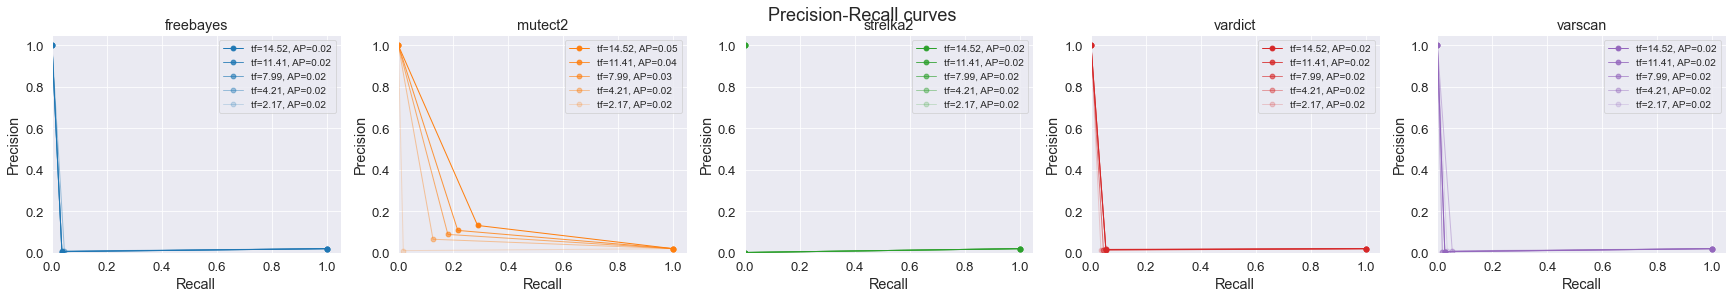

5287


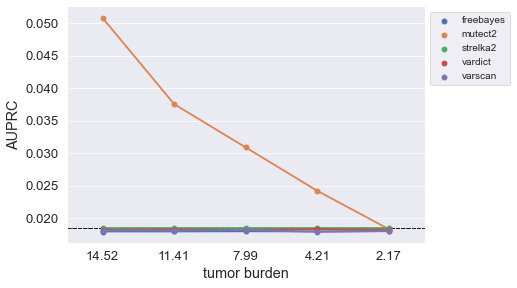

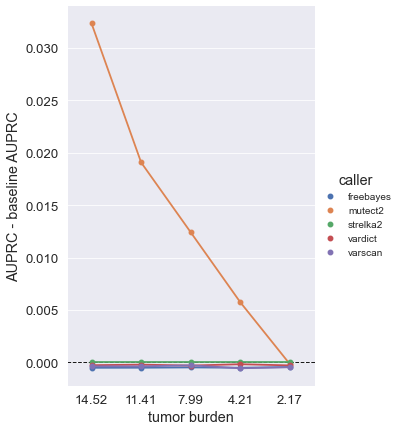

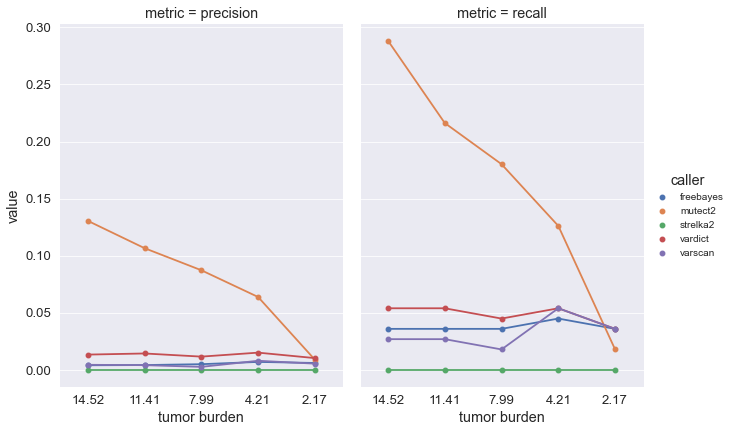

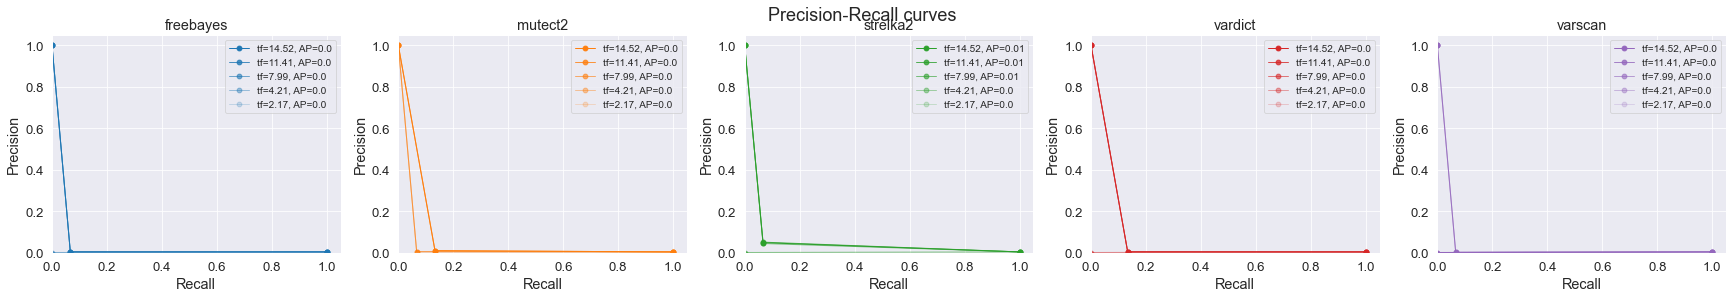

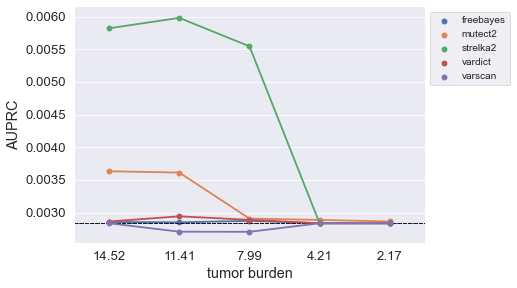

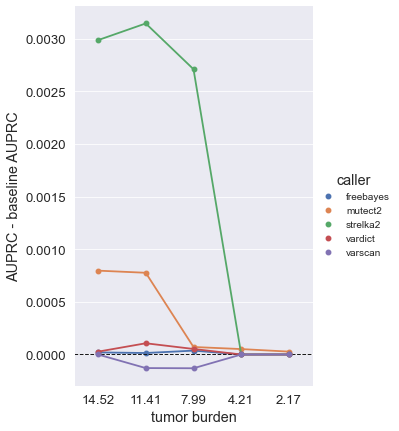

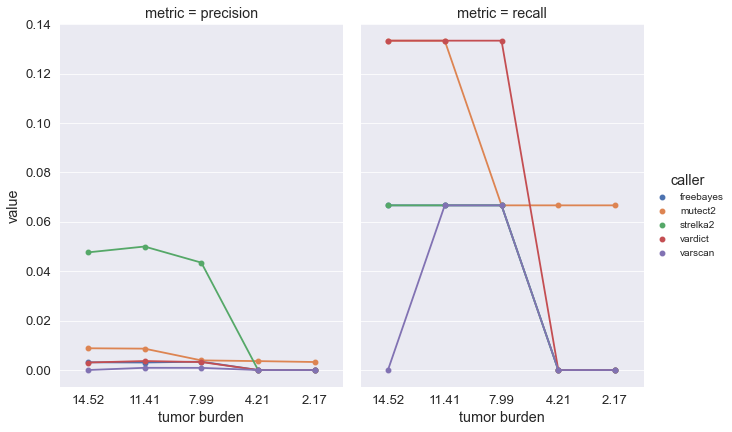

In [38]:
for mutation in ['snv', 'indel']:
    pd_methods = pd.DataFrame
    count = 0

    for mi, method in enumerate(['freebayes', 'mutect2', 'strelka2', 'vardict', 'varscan']):

        s0 = sample_0[['REF', 'ALT', 'QUAL', 'type', method]]
        s0.rename(columns = {method:'sample_0'},  inplace = True)
        st = sample_t[['REF', 'ALT', 'QUAL', 'type', method]]
        st.rename(columns = {method:'sample_t'},  inplace = True)
        s1 = sample_1[['REF', 'ALT', 'QUAL', 'type', method]]
        s1.rename(columns = {method:'sample_1'},  inplace = True)
        s2 = sample_2[['REF', 'ALT', 'QUAL', 'type', method]]
        s2.rename(columns = {method:'sample_2'},  inplace = True)
        s3 = sample_3[['REF', 'ALT', 'QUAL', 'type', method]]
        s3.rename(columns = {method:'sample_3'},  inplace = True)
        #s4 = sample_4[['REF', 'ALT', 'QUAL','type', method]]
        #s4.rename(columns = {method:'sample_4'},  inplace = True)
        #s5 = sample_5[['REF', 'ALT', 'QUAL','type', method]]
        #s5.rename(columns = {method:'sample_5'},  inplace = True)

        pd_method = pd.concat([s0.loc[~s0.index.duplicated()],
               st.loc[~st.index.duplicated()],
               s1.loc[~s1.index.duplicated()],
               s2.loc[~s2.index.duplicated()],
               s3.loc[~s3.index.duplicated()],
               s4.loc[~s4.index.duplicated()],
               s5.loc[~s5.index.duplicated()]], axis=1)

        pd_method['REF'] = [list(np.unique([i for i in list(ai) if str(i) != 'nan']))[-1] for ai in list(pd_method['REF'].values)]
        pd_method['ALT'] = [list(np.unique([i for i in list(ai) if str(i) != 'nan']))[-1] for ai in list(pd_method['ALT'].values)]
        pd_method = pd_method.T.drop_duplicates().T
        pd_method.columns = ['REF', 'ALT', 'QUAL_0', 'type_0', 'sample_0','QUAL_t', 'type_t', 'sample_t', 'QUAL_1', 'type_1', 'sample_1', 'QUAL_2', 'type_2', 'sample_2',  'QUAL_3', 'type_3', 'sample_3', 'QUAL_4', 'type_4', 'sample_4', 'QUAL_5', 'type_5', 'sample_5']
        pd_method[['sample_0', 'sample_t', 'sample_1', 'sample_2', 'sample_3', 'sample_4', 'sample_5']] = pd_method[['sample_0', 'sample_t', 'sample_1', 'sample_2', 'sample_3', 'sample_4', 'sample_5']].fillna(value=False)
        #pd_method.drop(pd_method[pd_method['sample_0'] + pd_method['sample_0_bis']+ pd_method['sample_1'] + pd_method['sample_2'] + pd_method['sample_3'] + pd_method['sample_4'] == False].index, axis=0, inplace=True)
        pd_method[['REF', 'sample_0', 'sample_t', 'sample_1', 'sample_2', 'sample_3', 'sample_4', 'sample_5']].head()
        pd_method['caller'] = method
        pd_method['type'] = pd_method[['type_0','type_t','type_1', 'type_2', 'type_3', 'type_4', 'type_5']].fillna('').sum(axis=1).apply(lambda x: pd.Series(x[:3]))

        if mutation == 'snv':
            pd_method = pd_method[pd_method['type'] == 'SNV']
        elif mutation == 'indel':
            pd_method = pd_method[(pd_method['type'] == 'INS') | (pd_method['type'] == 'DEL')]

        if count == 0:
            pd_methods = pd_method
            count = 1
        else:
            pd_methods = pd.concat([pd_methods, pd_method], join='inner')

    pd_results = pd.DataFrame.empty
    pd_results_PR = pd.DataFrame.empty
    count = 0

    fig, axs = plt.subplots(1,5,figsize=(30, 4))
    fig.suptitle('Precision-Recall curves')


    y_true = pd_methods[['sample_t', 'caller']]
    y_true.index.name = 'CHROM_POS'
    y_true = y_true.groupby(['CHROM_POS'])['sample_t'].sum()
    y_true[y_true <= 2] = 0
    y_true = y_true.astype(bool)
    print(y_true.shape[0])



    baselineAUPRC = {}

    for mi, method in enumerate(methods):

        res_df = (100*pd.Series(samples_tf)).round(decimals=2).to_frame(name='tumor burden')
        res_PR_df = (100*pd.Series(samples_tf)).round(decimals=2).to_frame(name='tumor burden')

        #y_true = pd_methods[pd_methods['caller'] == method]['sample_0'].astype(bool) + pd_methods[pd_methods['caller'] == method]['sample_0_bis'].astype(bool)
        baselineAUPRC[method] = len(y_true[y_true == True])/len(y_true)

        y_0 = pd_methods[pd_methods['caller'] == method]['sample_0'].astype(bool).reindex(y_true.index).squeeze()
        y_0 = y_0.fillna(False)
        y_1 = pd_methods[pd_methods['caller'] == method]['sample_1'].astype(bool).reindex(y_true.index).squeeze()
        y_1 = y_1.fillna(False)
        y_2 = pd_methods[pd_methods['caller'] == method]['sample_2'].astype(bool).reindex(y_true.index).squeeze()
        y_2 = y_2.fillna(False)
        y_3 = pd_methods[pd_methods['caller'] == method]['sample_3'].astype(bool).reindex(y_true.index).squeeze()
        y_3 = y_3.fillna(False)
        y_4 = pd_methods[pd_methods['caller'] == method]['sample_4'].astype(bool).reindex(y_true.index).squeeze()
        y_4 = y_4.fillna(False)
        y_5 = pd_methods[pd_methods['caller'] == method]['sample_5'].astype(bool).reindex(y_true.index).squeeze()
        y_5 = y_5.fillna(False)

        res_df['AUPRC'] = [average_precision_score(y_true, y_0),
                          average_precision_score(y_true, y_1),
                          average_precision_score(y_true, y_2),
                          average_precision_score(y_true, y_3),
                          average_precision_score(y_true, y_4),
                          average_precision_score(y_true, y_5),
                         ]
        res_df['AUPRC - baseline AUPRC'] = [average_precision_score(y_true, y_0) - baselineAUPRC[method],
                      average_precision_score(y_true, y_1) - baselineAUPRC[method],
                      average_precision_score(y_true, y_2) - baselineAUPRC[method],
                      average_precision_score(y_true, y_3) - baselineAUPRC[method],
                      average_precision_score(y_true, y_4) - baselineAUPRC[method],
                      average_precision_score(y_true, y_5) - baselineAUPRC[method],

                     ]
        res_PR_df['precision'] = [precision_score(y_true, y_0),
                          precision_score(y_true, y_1),
                          precision_score(y_true, y_2),
                          precision_score(y_true, y_3),
                          precision_score(y_true, y_4),
                          precision_score(y_true, y_5),
                         ]

        res_PR_df['recall'] = [recall_score(y_true, y_0),
                          recall_score(y_true, y_1),
                          recall_score(y_true, y_2),
                          recall_score(y_true, y_3),
                          recall_score(y_true, y_4),
                          recall_score(y_true, y_5),
                         ]
        res_PR_df = pd.melt(res_PR_df, id_vars =['tumor burden'], value_vars =['precision', 'recall'],
                        var_name='metric', value_name='value')
        res_df['caller'] = method
        res_PR_df['caller'] = method
        res_df.drop(['sample_0'], inplace=True)
        res_PR_df.drop([0, 6], inplace=True)

        # Plot Precision-Recall curve
        alpha_list = [0, 1, .8, .6, .4, .2, .1]
        for i in range(1,6):
            y_i = pd_methods[pd_methods['caller'] == method]['sample_'+str(i)].astype(bool).reindex(y_true.index).squeeze()
            y_i = y_i.fillna(False)
            precision, recall, _ = precision_recall_curve(y_true, y_i)
            axs[mi].plot(recall, precision, 'o-',
                                  label='tf='+str(res_df['tumor burden'].loc['sample_'+str(i)])+ ', AP='+str(round(average_precision_score(y_true, y_i), 2)),
                                  c=color_list[mi], alpha=alpha_list[i])
        axs[mi].set_xlabel('Recall')
        axs[mi].set_ylabel('Precision')
        axs[mi].set_ylim([0.0, 1.05])
        axs[mi].set_xlim([0.0, 1.05])
        axs[mi].set_title(method)
        axs[mi].legend()

        if count == 0:
            pd_results = res_df
            pd_results_PR = res_PR_df
            count = 1
        else:
            pd_results = pd.concat([pd_results, res_df], join='inner')
            pd_results_PR = pd.concat([pd_results_PR, res_PR_df], join='inner')
    plt.show()

    sns.catplot(x="tumor burden", y="AUPRC", hue="caller",  
                    capsize=.2, height=4, aspect=1.5,
                    kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results, legend=False)
    for mi, method in enumerate(methods):
        plt.axhline(y = baselineAUPRC[method], color = lc, linestyle = '--') 
    #plt.ylim([0, 0.5])
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")
    
    sns.catplot(x="tumor burden", y="AUPRC - baseline AUPRC", hue="caller",  
                capsize=.2, height=6, aspect=.75,
                kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results)
    plt.axhline(y = 0, color = lc, linestyle = '--', label='baseline AUPRC') 

    sns.catplot(x="tumor burden", y="value", col="metric", hue="caller",  
                    capsize=.2, height=6, aspect=.75,
                    kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results_PR)
    #plt.ylim([0, 0.5])

- Histograms of true allele frequencies in each tumor sample. Note how increasing admixture increases the prevalence of low- frequency variants.
- Benchmarking results for germline SNVs
- Benchmarking results for somatic SNVs on exome data.
- averaged over the four replicates

- add fake mutations on healthy mixtures

In [39]:
cov_pd = pd.read_csv('../data/CRC-986_300316_cov.txt', header=None)
cov_pd.index = [i for i in range(1,1002)]
cov_pd

0
1     1880935
2     1312716
3     1171549
4     1492055
5     1900432
...       ...
997     15728
998     15821
999     16007
1000    16136
1001  8327761

[1001 rows x 1 columns]

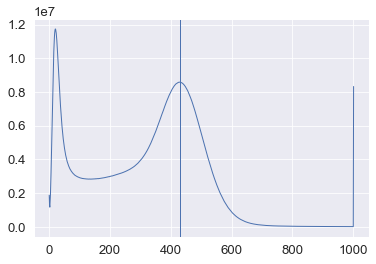

In [52]:
plt.plot(cov_pd.index, cov_pd.values)
plt.axvline(430)

In [43]:
cov_pd.describe()

0
count  1.001000e+03
mean   2.844013e+06
std    2.883503e+06
min    1.572800e+04
25%    5.442400e+04
50%    2.855419e+06
75%    4.320742e+06
max    1.174217e+07

([<matplotlib.axis.YTick at 0x7fb178a59b50>,
 [Text(0, 0.0, '0'),
  Text(0, 0.1, ''),
  Text(0, 0.2, ''),
  Text(0, 0.30000000000000004, ''),
  Text(0, 0.4, ''),
  Text(0, 0.5, '0.5'),
  Text(0, 0.6000000000000001, ''),
  Text(0, 0.7000000000000001, ''),
  Text(0, 0.8, ''),
  Text(0, 0.9, ''),
  Text(0, 1.0, '1')])

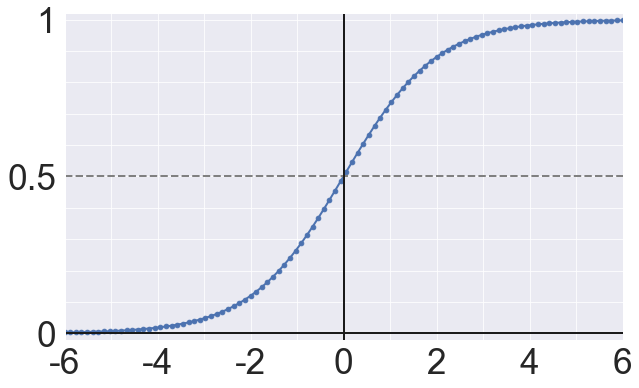

In [102]:
plt.rcParams.update({'font.size': 35})
sns.set(context="paper", font_scale=4, rc={"lines.linewidth": 2, "legend.fontsize":40})
x = np.linspace(-6,6,100)
def sigmoid(z, w, b):
    return 1/(1 + np.exp(-(w*z+b)))
plt.figure(figsize=(10, 6))
plt.scatter(x, sigmoid(x, 1, 0))
plt.plot(x, sigmoid(x, 1, 0)) #, label='w=1, b=0')
#plt.scatter(x, sigmoid(x, 10, 0))
#plt.plot(x, sigmoid(x, 10, 0), lw=2, label='w=10, b=0')
#plt.scatter(x, sigmoid(x, 0.1, 0))
#plt.plot(x, sigmoid(x, 0.1, 0), lw=2, label='w=0.1, b=0')
#plt.plot(x, sigmoid(x, 1, 1), label='w=1, b=1')
#plt.plot(x, sigmoid(x, 1, -1), label='w=1, b=-1')
plt.axhline(0.5, c='grey', ls='--')
plt.axvline(0, c='k')
plt.axhline(0, c='k')
plt.xticks(np.arange(-6, 7, step=1), ['-6', '', '-4', '', '-2', '', '0', '', '2', '', '4', '', '6'])
plt.xlim([-6,6])
plt.ylim([-0.02,1.02])
plt.yticks(np.arange(0, 1.1, step=0.1), ['0', '','','','','0.5', '','','','','1'])
#plt.xlabel('z')
#plt.ylabel('sigma(w.z+b)')
#plt.legend()

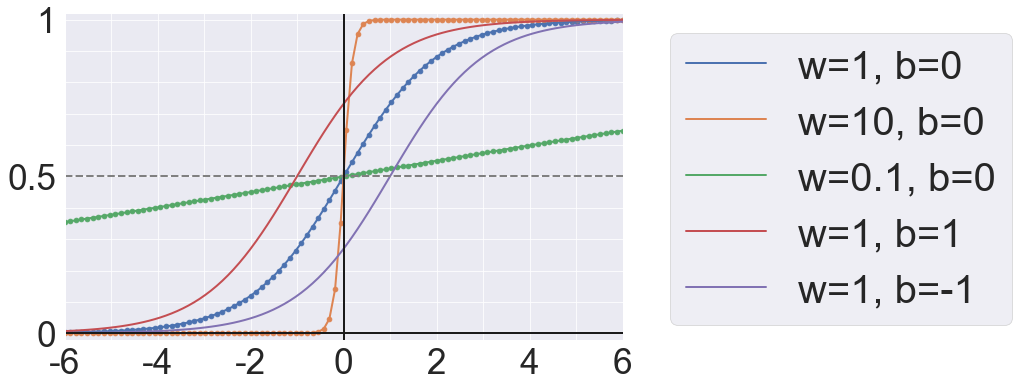

In [109]:
plt.rcParams.update({'font.size': 35})
sns.set(context="paper", font_scale=4, rc={"lines.linewidth": 2, "legend.fontsize":40})
x = np.linspace(-6,6,100)
def sigmoid(z, w, b):
    return 1/(1 + np.exp(-(w*z+b)))
plt.figure(figsize=(10, 6))
plt.scatter(x, sigmoid(x, 1, 0))
plt.plot(x, sigmoid(x, 1, 0), label='w=1, b=0')
plt.scatter(x, sigmoid(x, 10, 0))
plt.plot(x, sigmoid(x, 10, 0), label='w=10, b=0')
plt.scatter(x, sigmoid(x, 0.1, 0))
plt.plot(x, sigmoid(x, 0.1, 0),  label='w=0.1, b=0')
plt.plot(x, sigmoid(x, 1, 1), label='w=1, b=1')
plt.plot(x, sigmoid(x, 1, -1), label='w=1, b=-1')
plt.axhline(0.5, c='grey', ls='--')
plt.axvline(0, c='k')
plt.axhline(0, c='k')
plt.xticks(np.arange(-6, 7, step=1), ['-6', '', '-4', '', '-2', '', '0', '', '2', '', '4', '', '6'])
plt.xlim([-6,6])
plt.ylim([-0.02,1.02])
plt.yticks(np.arange(0, 1.1, step=0.1), ['0', '','','','','0.5', '','','','','1'])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

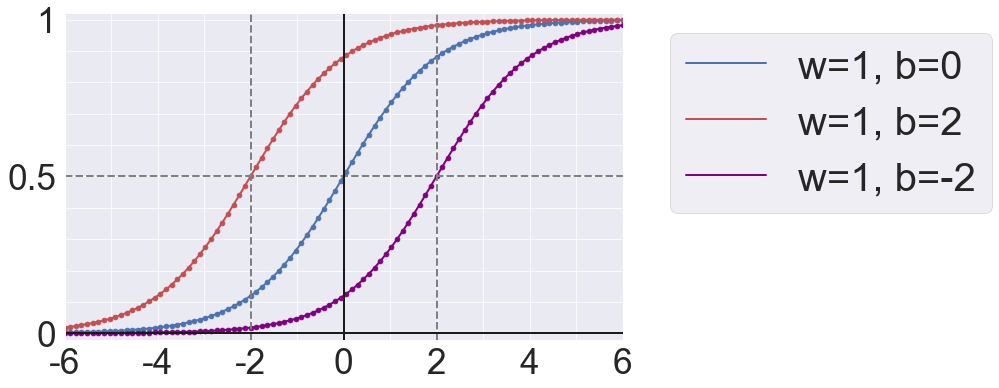

In [115]:
plt.rcParams.update({'font.size': 35})
sns.set(context="paper", font_scale=4, rc={"lines.linewidth": 2, "legend.fontsize":40})
x = np.linspace(-6,6,100)
def sigmoid(z, w, b):
    return 1/(1 + np.exp(-(w*z+b)))
plt.figure(figsize=(10, 6))
plt.scatter(x, sigmoid(x, 1, 0))
plt.plot(x, sigmoid(x, 1, 0), label='w=1, b=0')
plt.scatter(x, sigmoid(x, 1, 2), c='r')
plt.plot(x, sigmoid(x, 1, 2), label='w=1, b=2', c='r')
plt.scatter(x, sigmoid(x, 1, -2), c='purple')
plt.plot(x, sigmoid(x, 1, -2), label='w=1, b=-2', c='purple')
plt.axhline(0.5, c='grey', ls='--')
plt.axvline(-2, c='grey', ls='--')
plt.axvline(2, c='grey', ls='--')
plt.axvline(0, c='k')
plt.axhline(0, c='k')
plt.xticks(np.arange(-6, 7, step=1), ['-6', '', '-4', '', '-2', '', '0', '', '2', '', '4', '', '6'])
plt.xlim([-6,6])
plt.ylim([-0.02,1.02])
plt.yticks(np.arange(0, 1.1, step=0.1), ['0', '','','','','0.5', '','','','','1'])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')